In [1]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from model import EyeClassifierCNN

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 
import random

In [3]:
import wandb

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
dataset = datasets.ImageFolder(root="processed_dataset/training/", transform=transform)
val_dataset = datasets.ImageFolder(root="processed_dataset/validation/", transform=transform)

total_size = len(dataset)
train_size = int(0.9 * total_size)

test_size = total_size - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
dataset.class_to_idx

{'eye': 0, 'not_eye': 1}

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

In [10]:
def model_train(model, optimizer, criterion, dataloader):
    model.train()
    actual = []
    predicted = []
    for batch in dataloader:
        images, labels = batch
        labels = labels.to(device)
        images = images.to(device)
        labels = labels.unsqueeze(1).float()
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        for label in labels: actual.append(int(label.item()))
        for pred in preds: predicted.append(int(pred.item())) 
            
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    return actual, predicted


In [11]:
def model_eval(model, dataloader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            labels = labels.to(device)
            images = images.to(device)
            labels = labels.unsqueeze(1).float()
            
            preds = model(images)
            
            temp_label = []
            temp_pred = []
            
            # for label in labels: temp_label.append(label.item())
            # for pred in preds: temp_pred.append(round(pred.item(), 1))
            # print(temp_label)
            # print(temp_pred)
            
            for label in labels: actual.append(int(label.item()))
            for pred in preds: predicted.append(int(pred.item())) 
            
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    return actual, predicted

In [12]:
def create_confusion_matrix(actual,predicted, epoch):
    
    cm = confusion_matrix(actual,predicted)
    
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Eye','Not Eye'],
            yticklabels=['Eye','Not Eye'])
    plt.ylabel('Actual', fontsize=13)
    plt.title(f'Eval Confusion Matrix - Epoch #{epoch+1}', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [13]:
model = EyeClassifierCNN().to(device) 

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.0005

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 125

In [14]:
wandb.init(
    # set the wandb entity where your project will be logged (generally your team name)
    entity="oleksii-oliinyk-lviv-polytechnic-national-university",

    # set the wandb project where this run will be logged
    project="eye-validation-cnn",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "CNN",
    "dataset": "custom-dataset",
    "epochs": num_epochs,
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oleksii-oliinyk (oleksii-oliinyk-lviv-polytechnic-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
model_name = "validation_model_fixed_seed_8"

In [16]:
f = open("../info/logs/validation/" + model_name + ".txt", "w")

Epoch #1
Training: 
              precision    recall  f1-score   support

           0       0.65      0.97      0.78      1393
           1       0.97      0.66      0.79      2108

    accuracy                           0.78      3501
   macro avg       0.81      0.81      0.78      3501
weighted avg       0.84      0.78      0.78      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       154
           1       1.00      0.57      0.72       236

    accuracy                           0.74       390
   macro avg       0.80      0.78      0.74       390
weighted avg       0.84      0.74      0.73       390



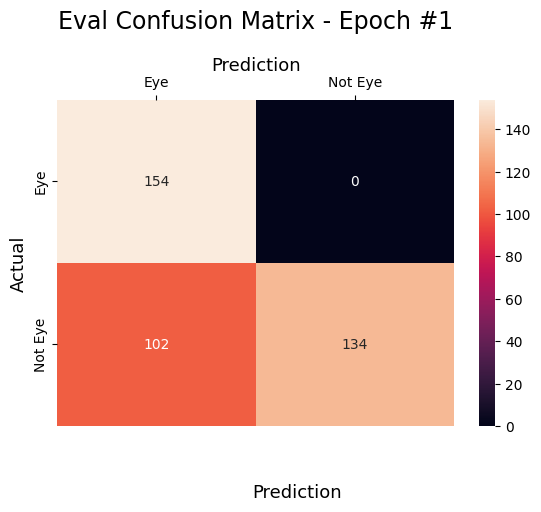

Epoch #2
Training: 
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1393
           1       0.98      0.74      0.85      2108

    accuracy                           0.84      3501
   macro avg       0.85      0.86      0.84      3501
weighted avg       0.88      0.84      0.84      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       154
           1       1.00      0.60      0.75       236

    accuracy                           0.76       390
   macro avg       0.81      0.80      0.76       390
weighted avg       0.85      0.76      0.76       390



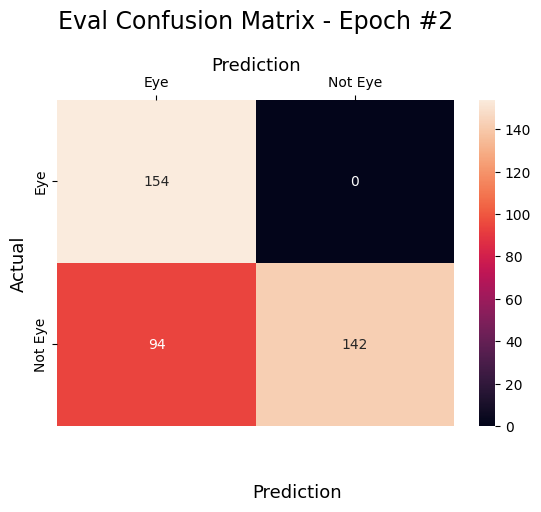

Epoch #3
Training: 
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1393
           1       0.98      0.77      0.86      2108

    accuracy                           0.85      3501
   macro avg       0.86      0.87      0.85      3501
weighted avg       0.88      0.85      0.85      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.67      0.95      0.78       154
           1       0.95      0.69      0.80       236

    accuracy                           0.79       390
   macro avg       0.81      0.82      0.79       390
weighted avg       0.84      0.79      0.80       390



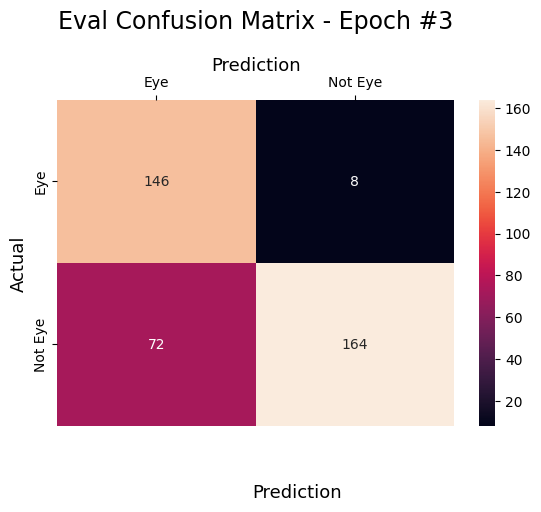

Epoch #4
Training: 
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      1393
           1       0.97      0.77      0.86      2108

    accuracy                           0.85      3501
   macro avg       0.85      0.87      0.85      3501
weighted avg       0.88      0.85      0.85      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.70      0.95      0.81       154
           1       0.96      0.73      0.83       236

    accuracy                           0.82       390
   macro avg       0.83      0.84      0.82       390
weighted avg       0.86      0.82      0.82       390



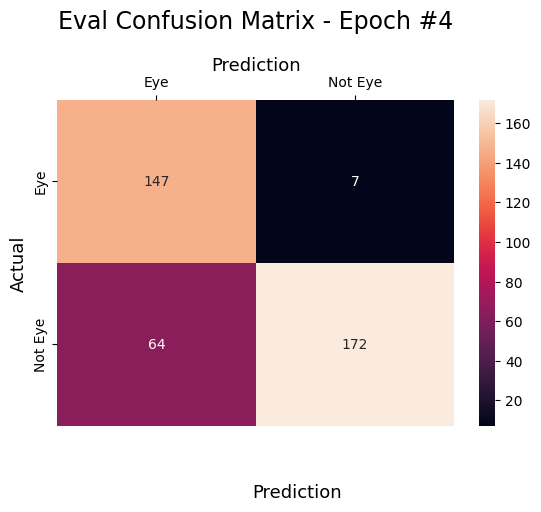

Epoch #5
Training: 
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1393
           1       0.97      0.83      0.90      2108

    accuracy                           0.88      3501
   macro avg       0.88      0.90      0.88      3501
weighted avg       0.90      0.88      0.88      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       154
           1       1.00      0.71      0.83       236

    accuracy                           0.82       390
   macro avg       0.85      0.85      0.82       390
weighted avg       0.88      0.82      0.82       390



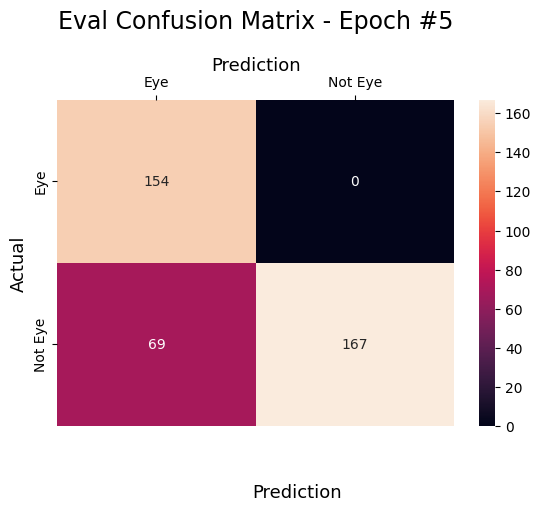

Epoch #6
Training: 
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1393
           1       0.98      0.81      0.89      2108

    accuracy                           0.88      3501
   macro avg       0.88      0.89      0.88      3501
weighted avg       0.90      0.88      0.88      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       154
           1       0.95      0.90      0.93       236

    accuracy                           0.91       390
   macro avg       0.91      0.92      0.91       390
weighted avg       0.92      0.91      0.91       390



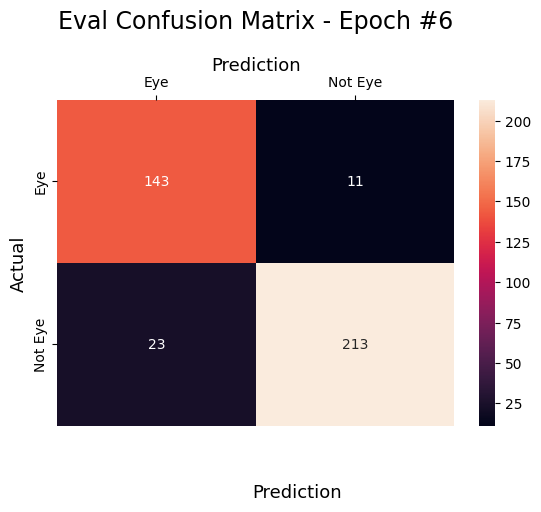

Epoch #7
Training: 
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      1393
           1       0.96      0.81      0.88      2108

    accuracy                           0.87      3501
   macro avg       0.87      0.88      0.86      3501
weighted avg       0.89      0.87      0.87      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       154
           1       1.00      0.63      0.77       236

    accuracy                           0.77       390
   macro avg       0.82      0.81      0.77       390
weighted avg       0.86      0.77      0.77       390



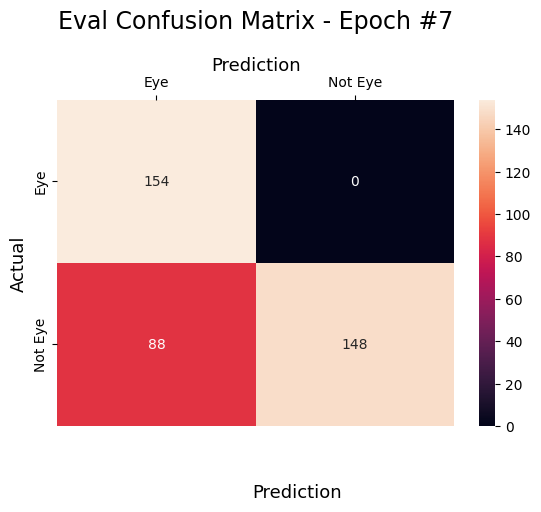

Epoch #8
Training: 
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1393
           1       0.98      0.88      0.93      2108

    accuracy                           0.92      3501
   macro avg       0.91      0.93      0.92      3501
weighted avg       0.93      0.92      0.92      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       154
           1       0.98      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.94      0.94       390



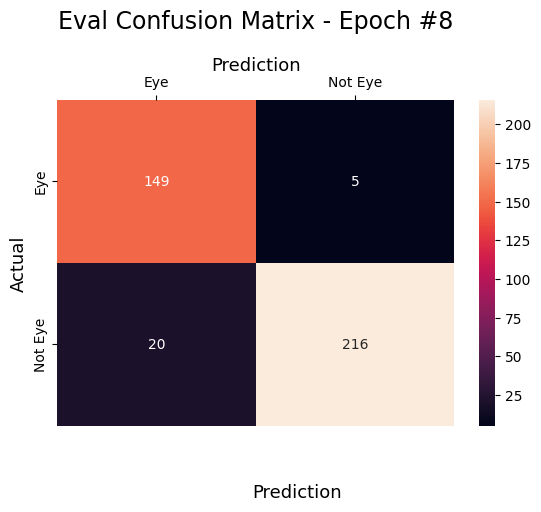

Epoch #9
Training: 
              precision    recall  f1-score   support

           0       0.80      0.97      0.87      1393
           1       0.98      0.84      0.90      2108

    accuracy                           0.89      3501
   macro avg       0.89      0.90      0.89      3501
weighted avg       0.90      0.89      0.89      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.70      0.95      0.80       154
           1       0.96      0.73      0.83       236

    accuracy                           0.82       390
   macro avg       0.83      0.84      0.82       390
weighted avg       0.85      0.82      0.82       390



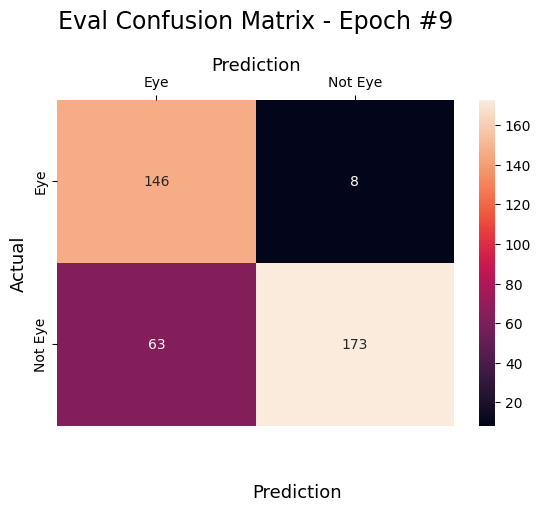

Epoch #10
Training: 
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1393
           1       0.97      0.83      0.89      2108

    accuracy                           0.88      3501
   macro avg       0.88      0.89      0.88      3501
weighted avg       0.90      0.88      0.88      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       154
           1       1.00      0.49      0.66       236

    accuracy                           0.69       390
   macro avg       0.78      0.74      0.69       390
weighted avg       0.83      0.69      0.68       390



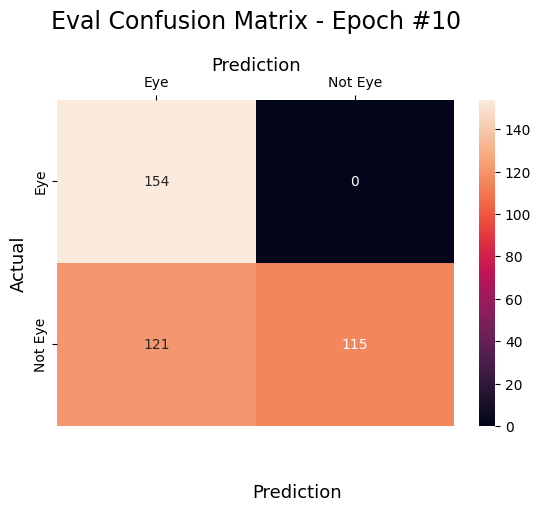

Epoch #11
Training: 
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      1393
           1       0.99      0.71      0.83      2108

    accuracy                           0.82      3501
   macro avg       0.84      0.85      0.82      3501
weighted avg       0.87      0.82      0.82      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       154
           1       0.96      0.87      0.91       236

    accuracy                           0.90       390
   macro avg       0.89      0.91      0.90       390
weighted avg       0.91      0.90      0.90       390



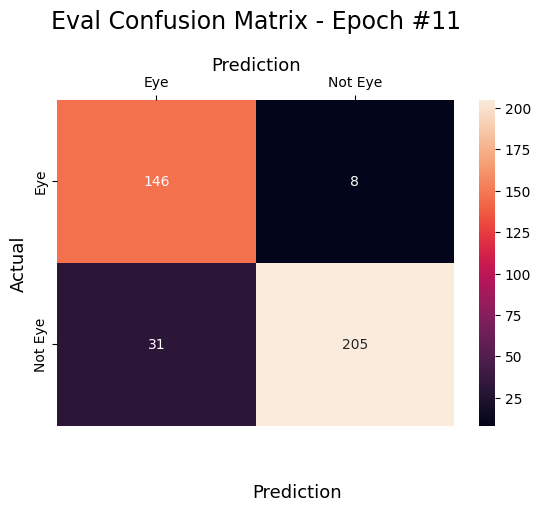

Epoch #12
Training: 
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1393
           1       0.98      0.85      0.91      2108

    accuracy                           0.90      3501
   macro avg       0.89      0.91      0.89      3501
weighted avg       0.91      0.90      0.90      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       154
           1       0.96      0.77      0.85       236

    accuracy                           0.84       390
   macro avg       0.84      0.86      0.84       390
weighted avg       0.87      0.84      0.84       390



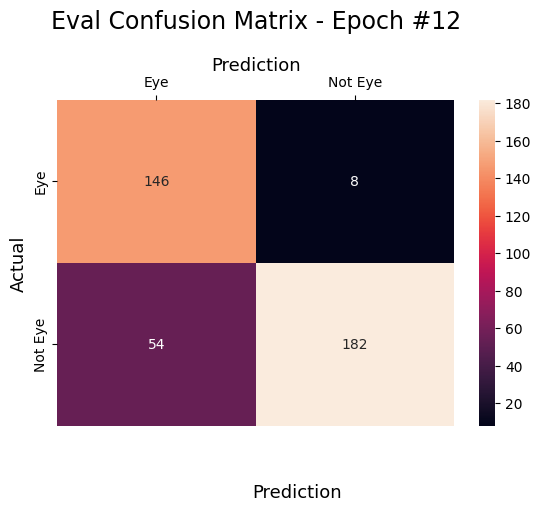

Epoch #13
Training: 
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      1393
           1       0.97      0.79      0.87      2108

    accuracy                           0.86      3501
   macro avg       0.86      0.88      0.86      3501
weighted avg       0.89      0.86      0.86      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       154
           1       0.97      0.77      0.86       236

    accuracy                           0.85       390
   macro avg       0.85      0.87      0.85       390
weighted avg       0.88      0.85      0.85       390



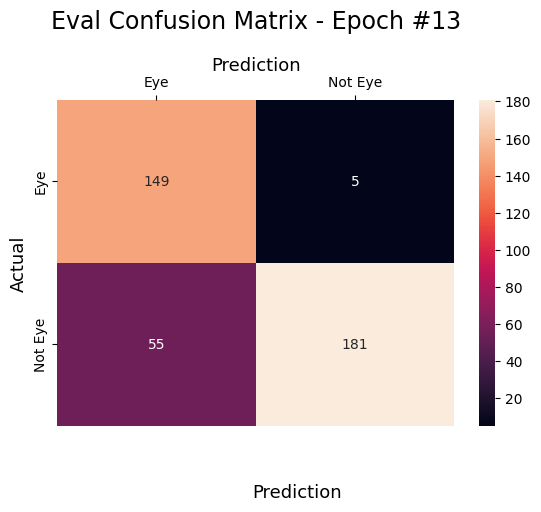

Epoch #14
Training: 
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1393
           1       0.98      0.85      0.91      2108

    accuracy                           0.90      3501
   macro avg       0.90      0.91      0.90      3501
weighted avg       0.91      0.90      0.90      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



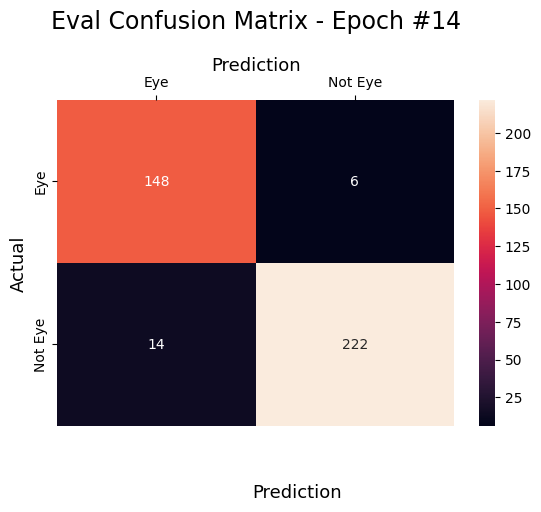

Epoch #15
Training: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1393
           1       0.98      0.89      0.93      2108

    accuracy                           0.93      3501
   macro avg       0.92      0.93      0.92      3501
weighted avg       0.93      0.93      0.93      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       154
           1       0.97      0.81      0.88       236

    accuracy                           0.87       390
   macro avg       0.87      0.89      0.87       390
weighted avg       0.89      0.87      0.87       390



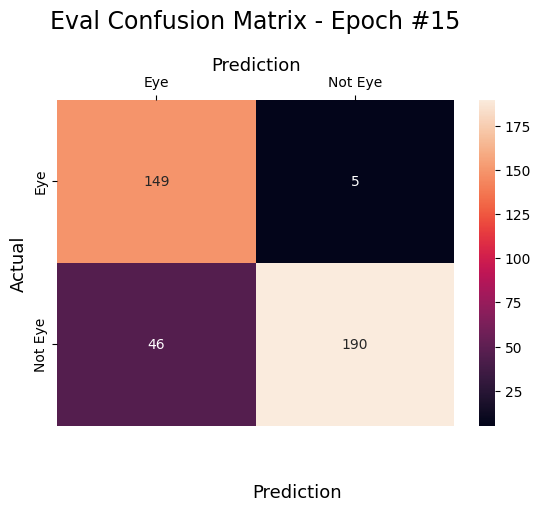

Epoch #16
Training: 
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1393
           1       0.99      0.78      0.87      2108

    accuracy                           0.86      3501
   macro avg       0.87      0.88      0.86      3501
weighted avg       0.89      0.86      0.86      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       154
           1       0.97      0.74      0.84       236

    accuracy                           0.83       390
   macro avg       0.84      0.85      0.83       390
weighted avg       0.87      0.83      0.83       390



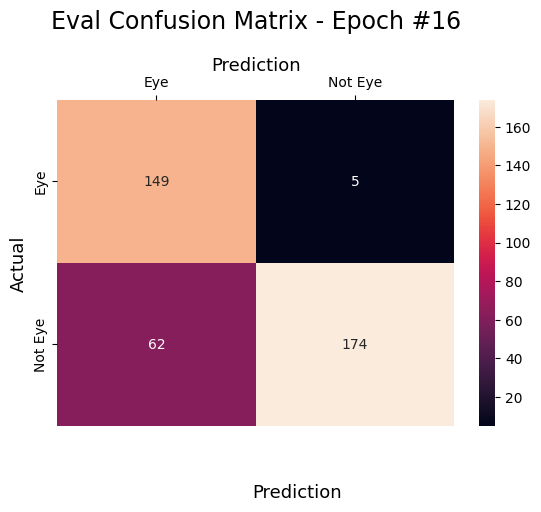

Epoch #17
Training: 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1393
           1       0.98      0.86      0.92      2108

    accuracy                           0.90      3501
   macro avg       0.90      0.92      0.90      3501
weighted avg       0.92      0.90      0.91      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       154
           1       0.86      0.91      0.89       236

    accuracy                           0.86       390
   macro avg       0.86      0.85      0.85       390
weighted avg       0.86      0.86      0.86       390



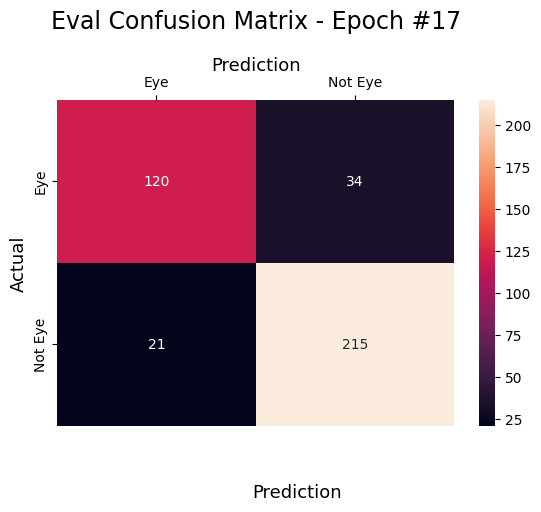

Epoch #18
Training: 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1393
           1       0.96      0.86      0.91      2108

    accuracy                           0.90      3501
   macro avg       0.89      0.91      0.90      3501
weighted avg       0.91      0.90      0.90      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       154
           1       0.96      0.91      0.94       236

    accuracy                           0.93       390
   macro avg       0.92      0.93      0.92       390
weighted avg       0.93      0.93      0.93       390



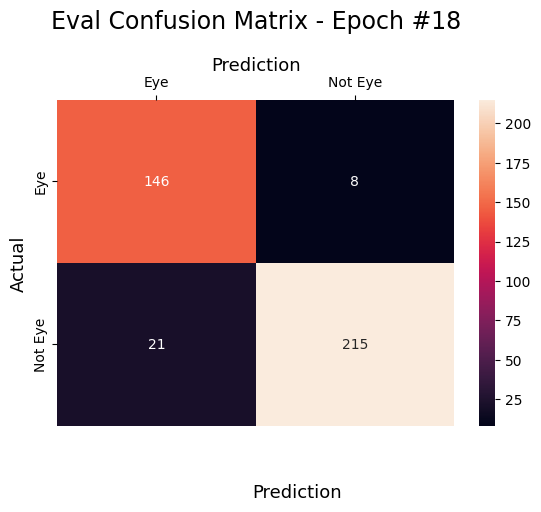

Epoch #19
Training: 
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1393
           1       0.95      0.92      0.94      2108

    accuracy                           0.92      3501
   macro avg       0.92      0.93      0.92      3501
weighted avg       0.93      0.92      0.93      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       154
           1       0.87      0.87      0.87       236

    accuracy                           0.84       390
   macro avg       0.83      0.83      0.83       390
weighted avg       0.84      0.84      0.84       390



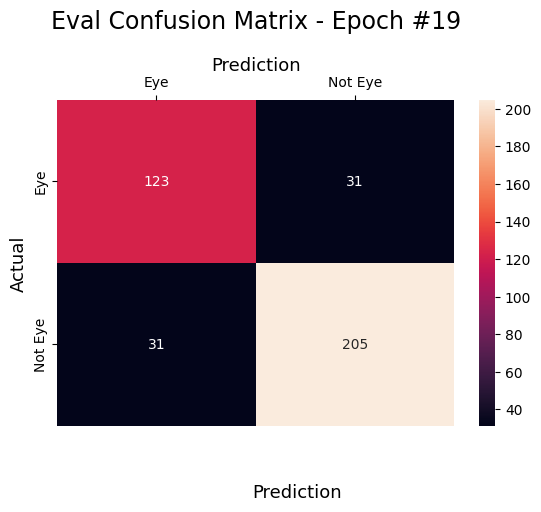

Epoch #20
Training: 
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1393
           1       0.91      0.80      0.85      2108

    accuracy                           0.83      3501
   macro avg       0.82      0.84      0.83      3501
weighted avg       0.84      0.83      0.83      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       154
           1       0.98      0.84      0.90       236

    accuracy                           0.89       390
   macro avg       0.89      0.91      0.89       390
weighted avg       0.91      0.89      0.89       390



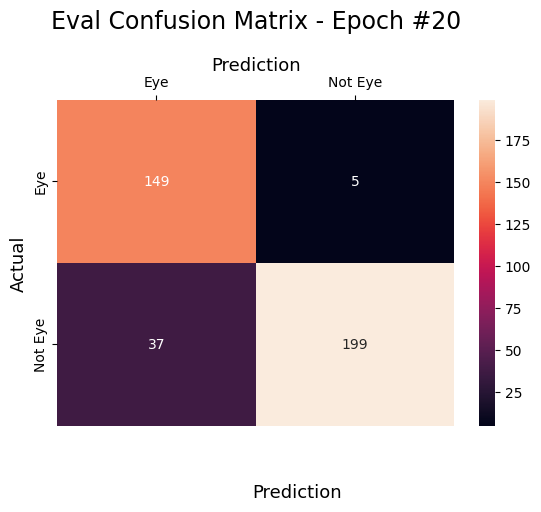

Epoch #21
Training: 
              precision    recall  f1-score   support

           0       0.85      0.96      0.91      1393
           1       0.97      0.89      0.93      2108

    accuracy                           0.92      3501
   macro avg       0.91      0.93      0.92      3501
weighted avg       0.93      0.92      0.92      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       154
           1       0.96      0.86      0.91       236

    accuracy                           0.89       390
   macro avg       0.89      0.90      0.89       390
weighted avg       0.90      0.89      0.89       390



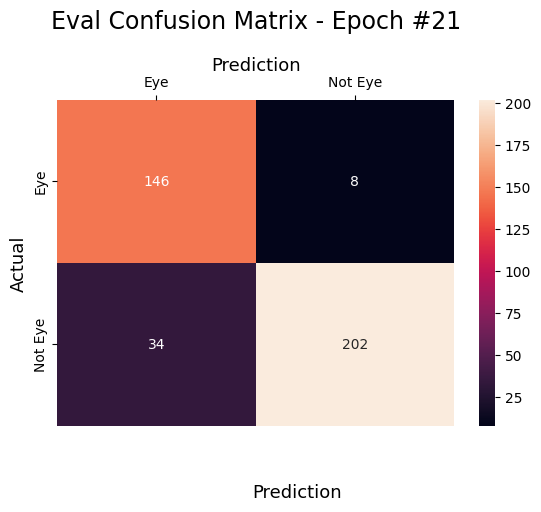

Epoch #22
Training: 
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1393
           1       0.97      0.86      0.91      2108

    accuracy                           0.90      3501
   macro avg       0.90      0.91      0.90      3501
weighted avg       0.91      0.90      0.90      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       154
           1       0.95      0.79      0.86       236

    accuracy                           0.85       390
   macro avg       0.85      0.86      0.85       390
weighted avg       0.87      0.85      0.85       390



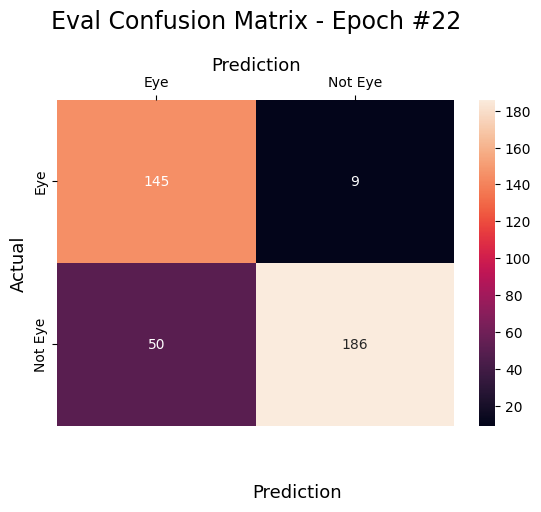

Epoch #23
Training: 
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1393
           1       0.98      0.81      0.89      2108

    accuracy                           0.88      3501
   macro avg       0.88      0.89      0.88      3501
weighted avg       0.90      0.88      0.88      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.72      0.97      0.82       154
           1       0.97      0.75      0.85       236

    accuracy                           0.84       390
   macro avg       0.84      0.86      0.84       390
weighted avg       0.87      0.84      0.84       390



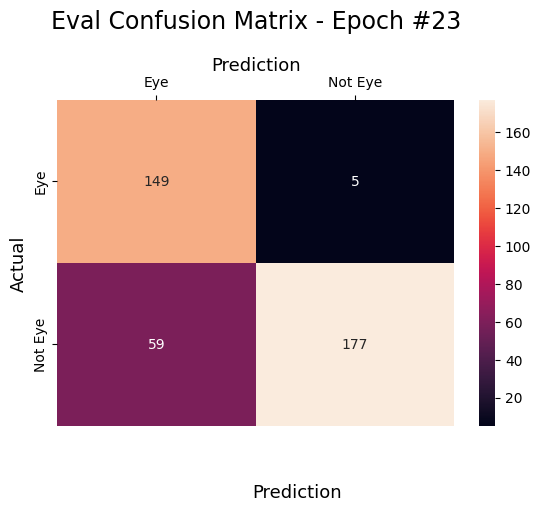

Epoch #24
Training: 
              precision    recall  f1-score   support

           0       0.73      0.98      0.83      1393
           1       0.98      0.76      0.85      2108

    accuracy                           0.85      3501
   macro avg       0.85      0.87      0.84      3501
weighted avg       0.88      0.85      0.85      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       154
           1       0.97      0.82      0.89       236

    accuracy                           0.88       390
   macro avg       0.88      0.89      0.88       390
weighted avg       0.90      0.88      0.88       390



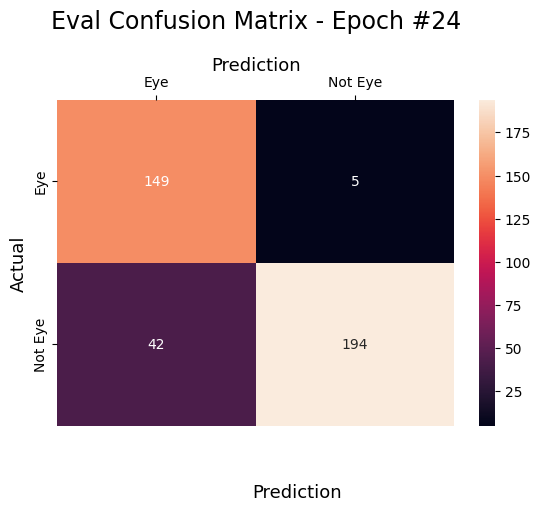

Epoch #25
Training: 
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1393
           1       0.98      0.84      0.91      2108

    accuracy                           0.90      3501
   macro avg       0.89      0.91      0.89      3501
weighted avg       0.91      0.90      0.90      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       154
           1       0.98      0.90      0.94       236

    accuracy                           0.93       390
   macro avg       0.92      0.94      0.93       390
weighted avg       0.93      0.93      0.93       390



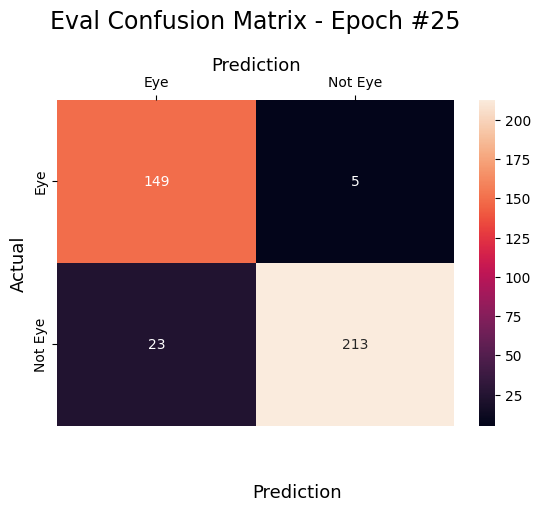

Epoch #26
Training: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.92      1393
           1       0.98      0.92      0.95      2108

    accuracy                           0.94      3501
   macro avg       0.93      0.94      0.94      3501
weighted avg       0.94      0.94      0.94      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       154
           1       0.87      0.93      0.90       236

    accuracy                           0.87       390
   macro avg       0.87      0.86      0.86       390
weighted avg       0.87      0.87      0.87       390



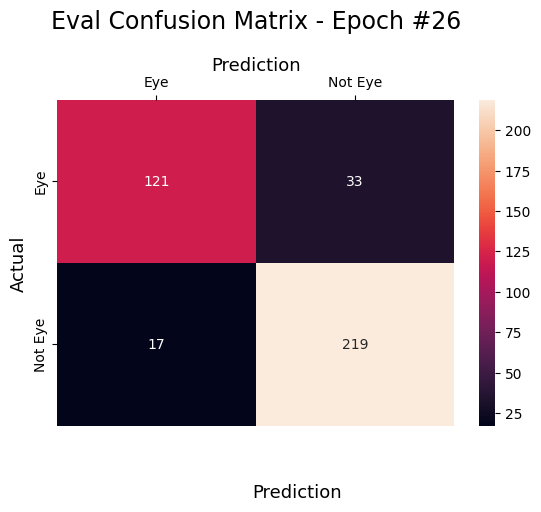

Epoch #27
Training: 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1393
           1       0.88      0.83      0.85      2108

    accuracy                           0.83      3501
   macro avg       0.82      0.83      0.82      3501
weighted avg       0.83      0.83      0.83      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       154
           1       0.94      0.76      0.84       236

    accuracy                           0.82       390
   macro avg       0.83      0.84      0.82       390
weighted avg       0.85      0.82      0.83       390



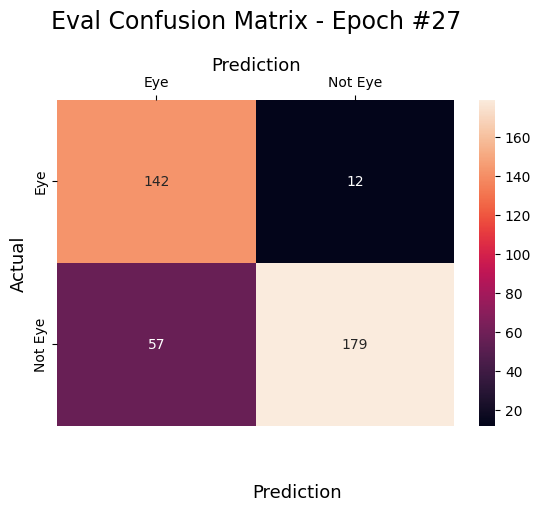

Epoch #28
Training: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1393
           1       0.96      0.88      0.92      2108

    accuracy                           0.91      3501
   macro avg       0.90      0.92      0.91      3501
weighted avg       0.92      0.91      0.91      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       154
           1       0.96      0.92      0.94       236

    accuracy                           0.93       390
   macro avg       0.92      0.93      0.93       390
weighted avg       0.93      0.93      0.93       390



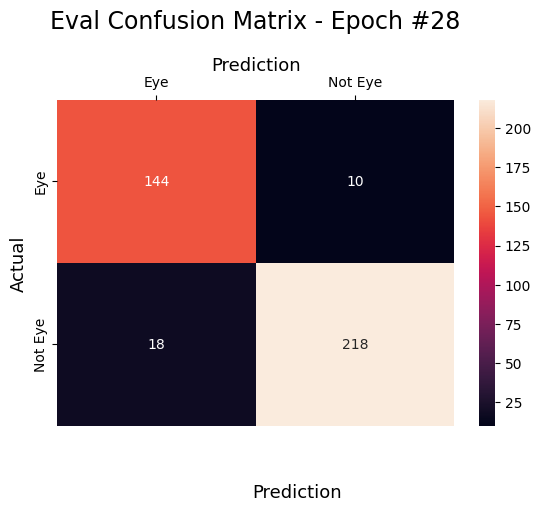

Epoch #29
Training: 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1393
           1       0.97      0.94      0.95      2108

    accuracy                           0.94      3501
   macro avg       0.94      0.94      0.94      3501
weighted avg       0.94      0.94      0.94      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       154
           1       0.96      0.87      0.91       236

    accuracy                           0.90       390
   macro avg       0.89      0.91      0.90       390
weighted avg       0.91      0.90      0.90       390



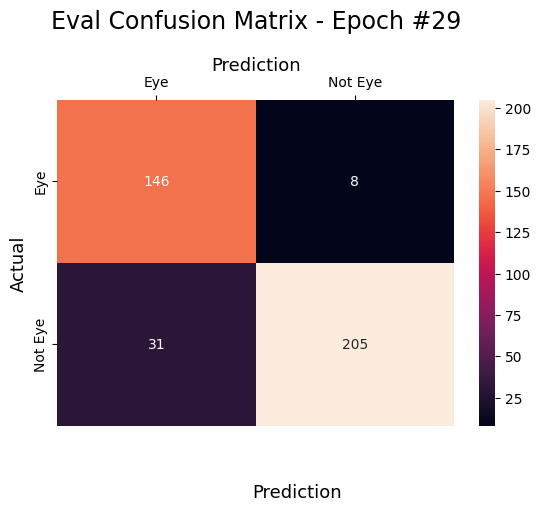

Epoch #30
Training: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1393
           1       0.97      0.95      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.95      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



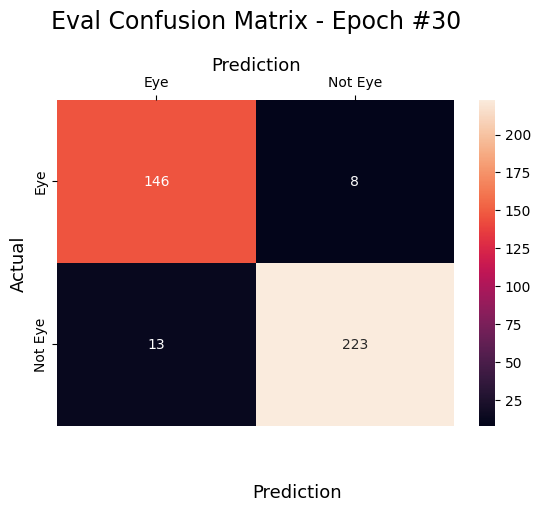

Epoch #31
Training: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1393
           1       0.98      0.95      0.96      2108

    accuracy                           0.96      3501
   macro avg       0.95      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



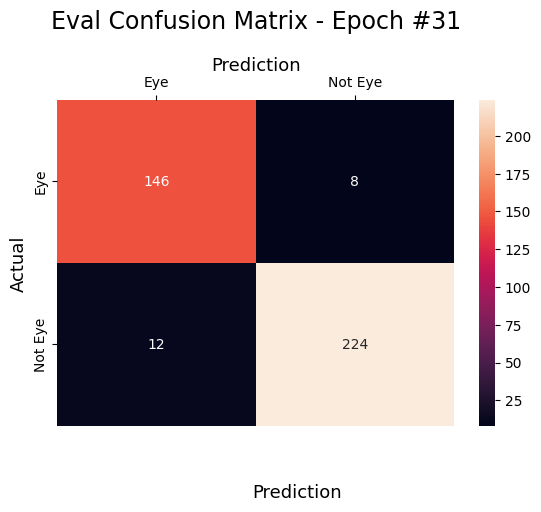

Epoch #32
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1393
           1       0.98      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.94      0.95      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       154
           1       0.98      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.94      0.94       390



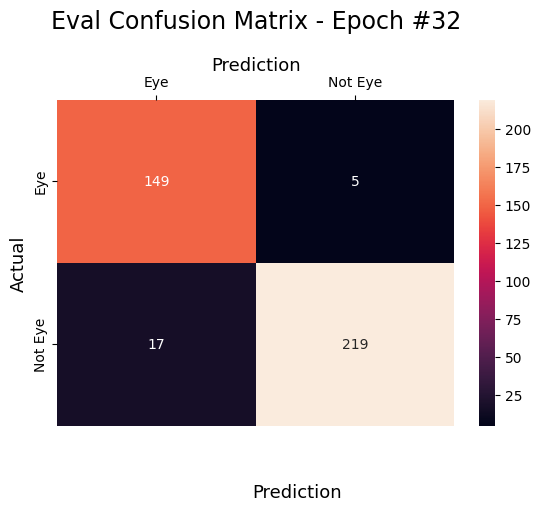

Epoch #33
Training: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1393
           1       0.98      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.95      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.69      0.97      0.81       154
           1       0.97      0.72      0.83       236

    accuracy                           0.82       390
   macro avg       0.83      0.84      0.82       390
weighted avg       0.86      0.82      0.82       390



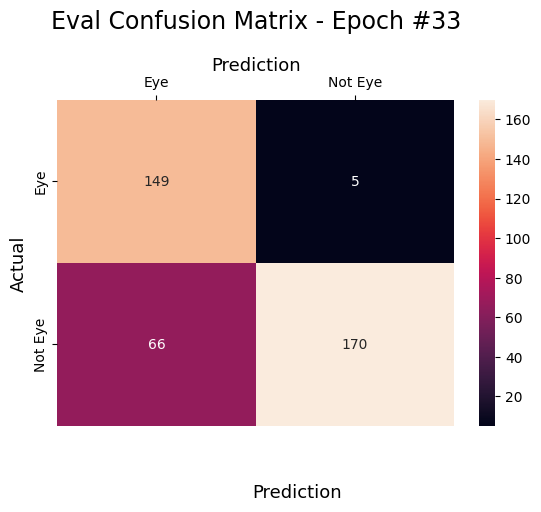

Epoch #34
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1393
           1       0.99      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.94      0.95      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       154
           1       0.98      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



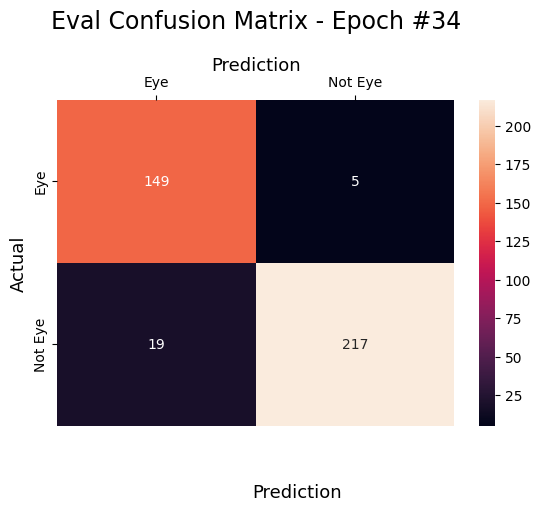

Epoch #35
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



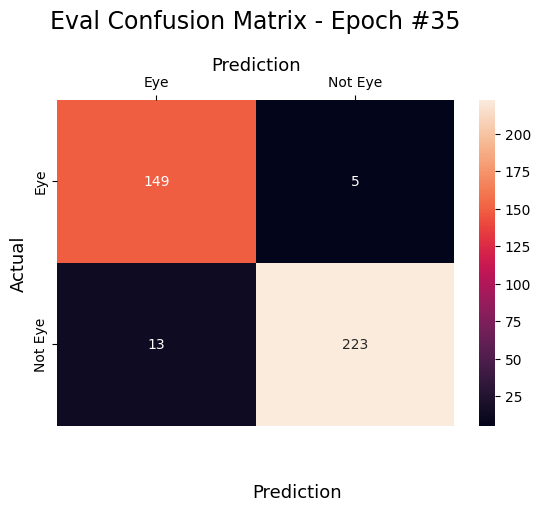

Epoch #36
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1393
           1       0.99      0.94      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.96      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       154
           1       0.97      0.89      0.93       236

    accuracy                           0.92       390
   macro avg       0.91      0.92      0.91       390
weighted avg       0.92      0.92      0.92       390



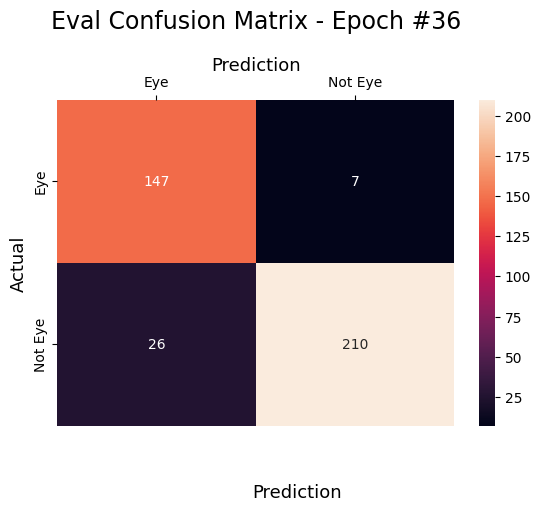

Epoch #37
Training: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1393
           1       0.98      0.91      0.95      2108

    accuracy                           0.94      3501
   macro avg       0.93      0.95      0.94      3501
weighted avg       0.94      0.94      0.94      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       154
           1       0.93      0.97      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.93      0.94       390
weighted avg       0.94      0.94      0.94       390



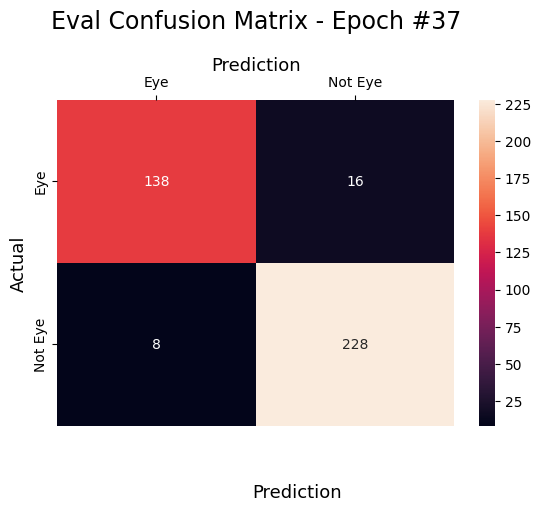

Epoch #38
Training: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1393
           1       0.98      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       154
           1       0.97      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



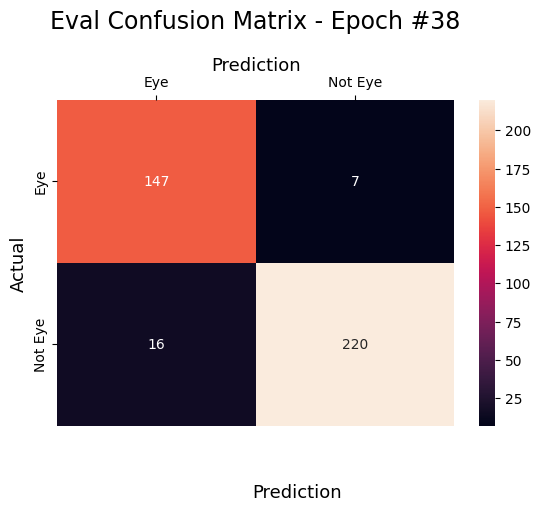

Epoch #39
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1393
           1       0.98      0.93      0.95      2108

    accuracy                           0.95      3501
   macro avg       0.94      0.95      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



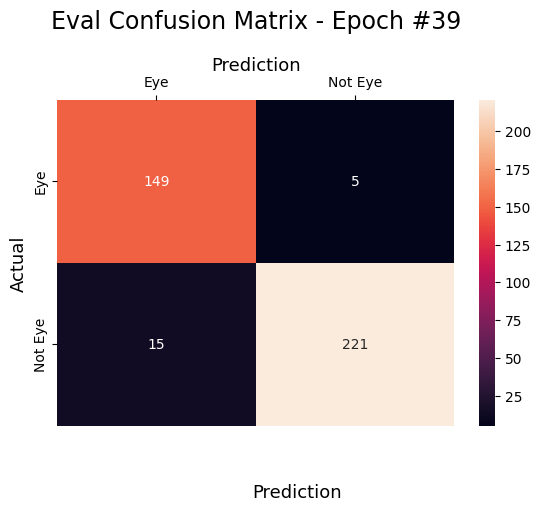

Epoch #40
Training: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1393
           1       0.98      0.95      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       154
           1       0.97      0.92      0.94       236

    accuracy                           0.93       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.93      0.93       390



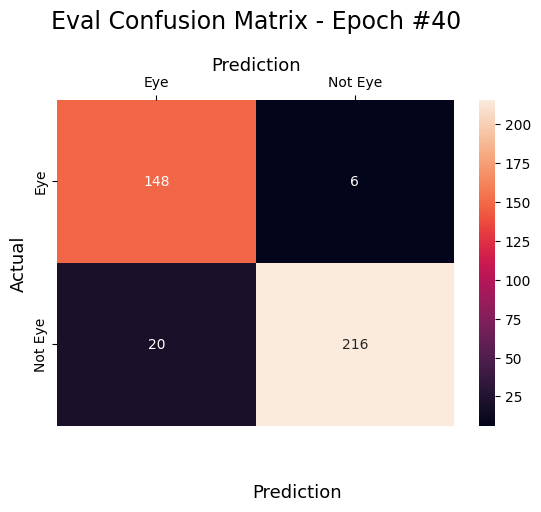

Epoch #41
Training: 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1393
           1       0.98      0.90      0.94      2108

    accuracy                           0.93      3501
   macro avg       0.93      0.94      0.93      3501
weighted avg       0.94      0.93      0.93      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       154
           1       0.98      0.82      0.89       236

    accuracy                           0.88       390
   macro avg       0.88      0.90      0.88       390
weighted avg       0.90      0.88      0.88       390



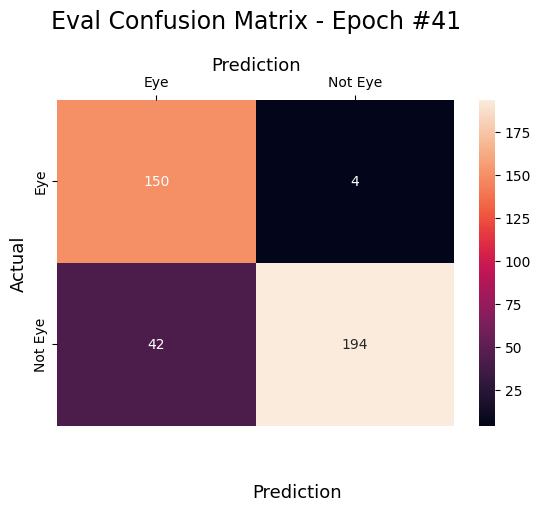

Epoch #42
Training: 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1393
           1       0.99      0.88      0.93      2108

    accuracy                           0.92      3501
   macro avg       0.91      0.93      0.92      3501
weighted avg       0.93      0.92      0.92      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       154
           1       0.97      0.80      0.88       236

    accuracy                           0.87       390
   macro avg       0.87      0.88      0.87       390
weighted avg       0.89      0.87      0.87       390



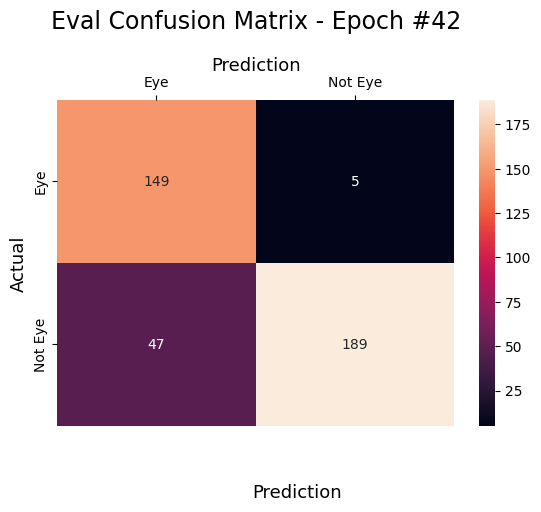

Epoch #43
Training: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1393
           1       0.99      0.91      0.95      2108

    accuracy                           0.94      3501
   macro avg       0.93      0.95      0.94      3501
weighted avg       0.95      0.94      0.94      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       154
           1       0.98      0.85      0.91       236

    accuracy                           0.90       390
   macro avg       0.89      0.91      0.90       390
weighted avg       0.91      0.90      0.90       390



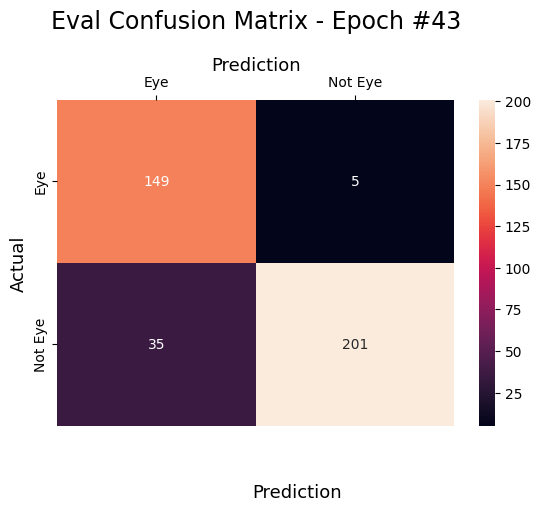

Epoch #44
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1393
           1       0.99      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       154
           1       0.97      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



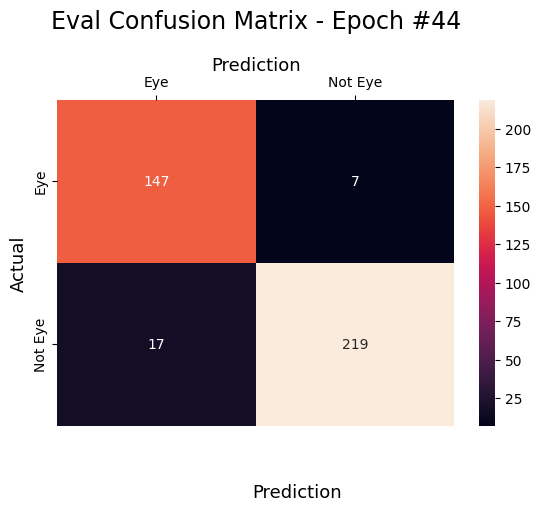

Epoch #45
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



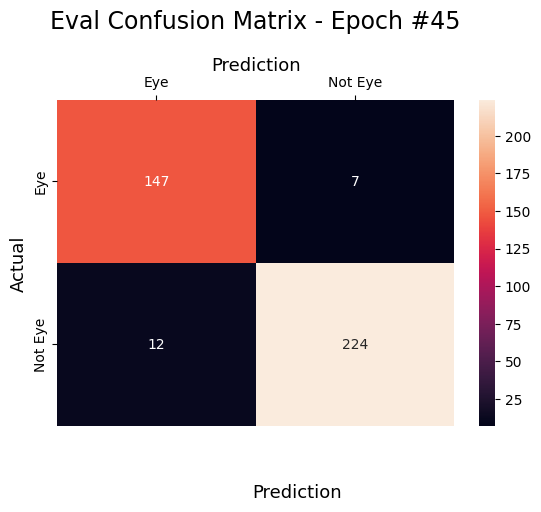

Epoch #46
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.98      0.96      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.97      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



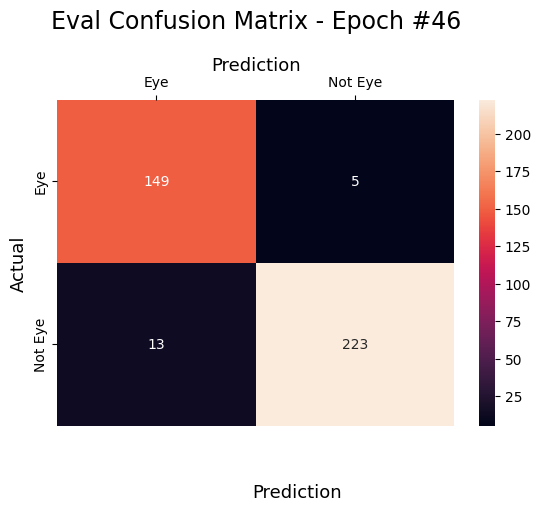

Epoch #47
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       154
           1       0.97      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.94      0.94       390



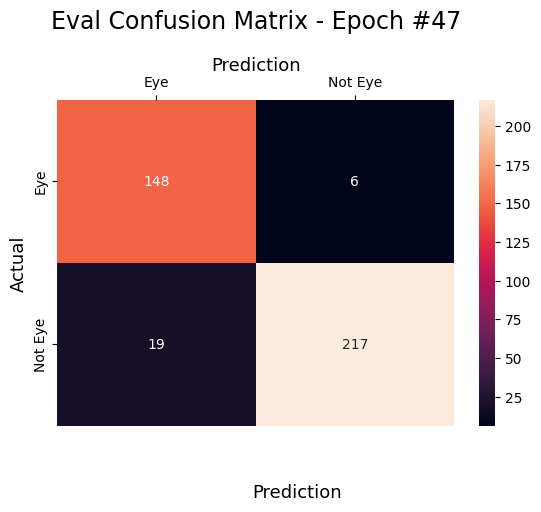

Epoch #48
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1393
           1       0.99      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



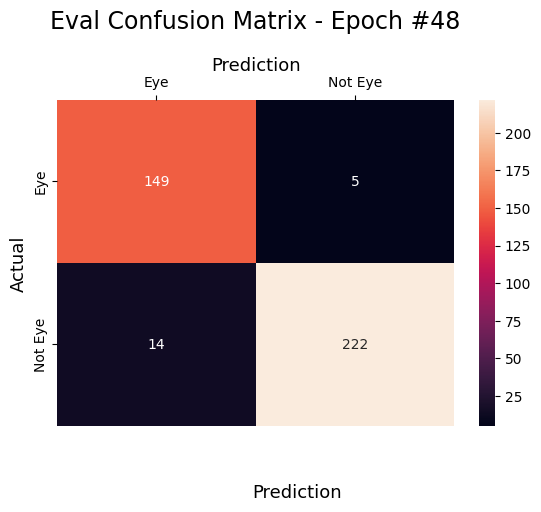

Epoch #49
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1393
           1       0.98      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       154
           1       0.98      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



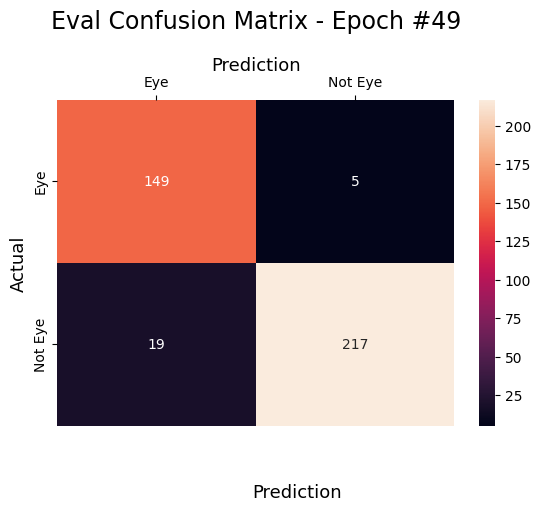

Epoch #50
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1393
           1       0.99      0.94      0.96      2108

    accuracy                           0.96      3501
   macro avg       0.95      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       154
           1       0.97      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



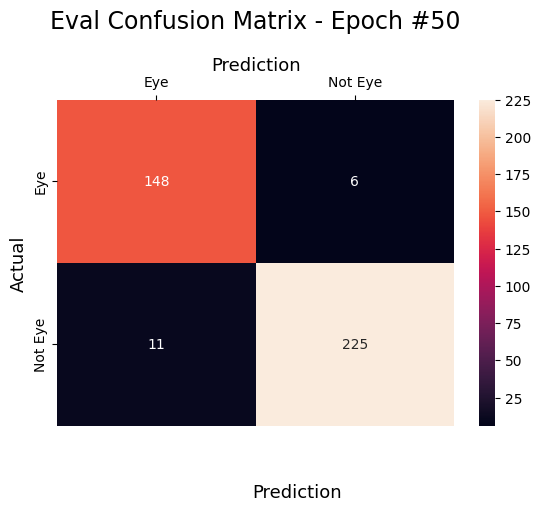

Epoch #51
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



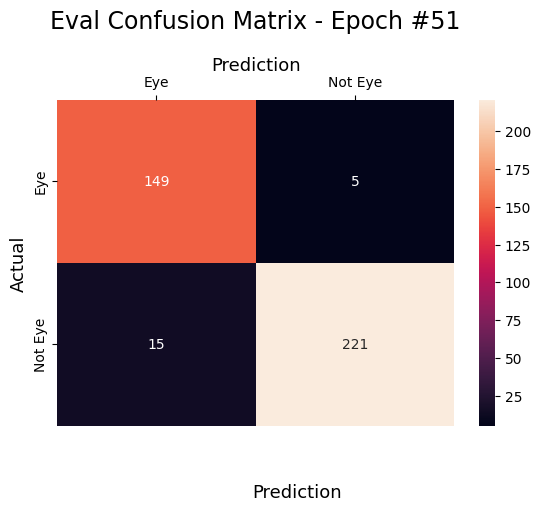

Epoch #52
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



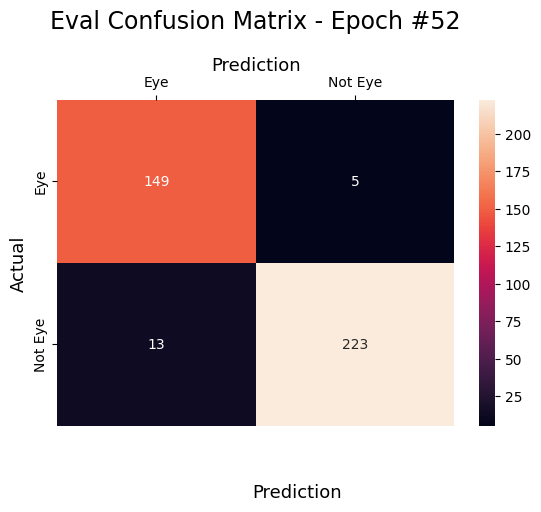

Epoch #53
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



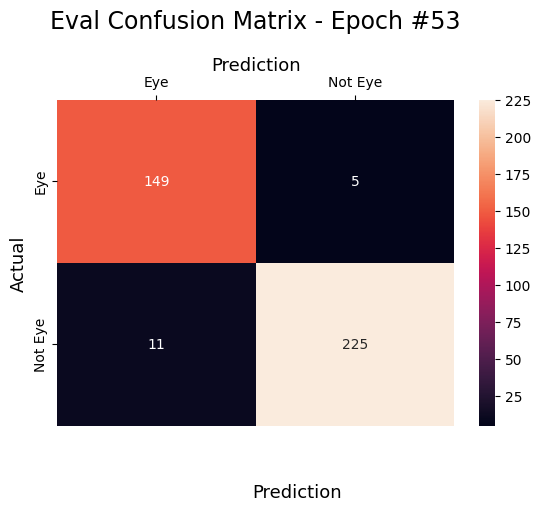

Epoch #54
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



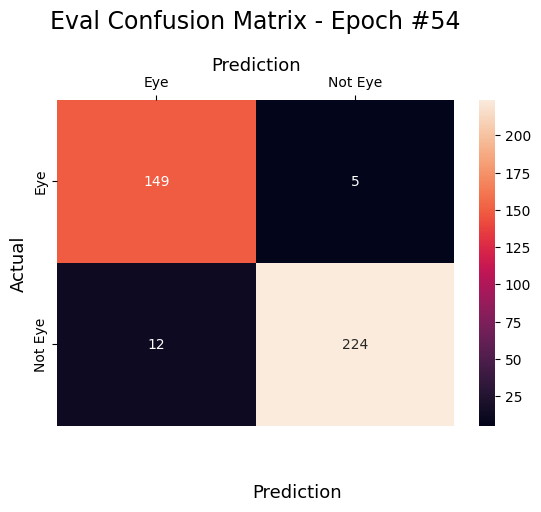

Epoch #55
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       154
           1       0.98      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.94      0.94       390



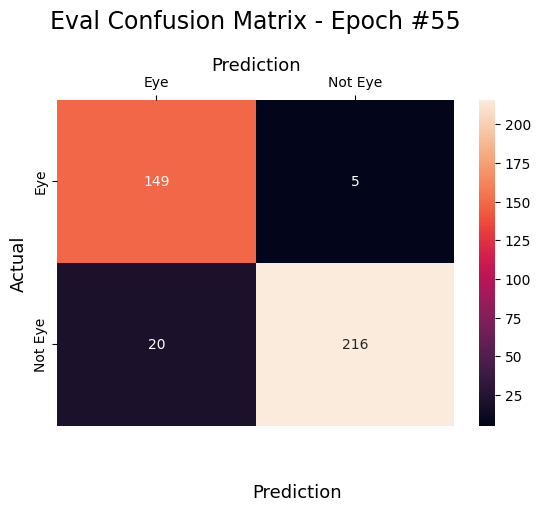

Epoch #56
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



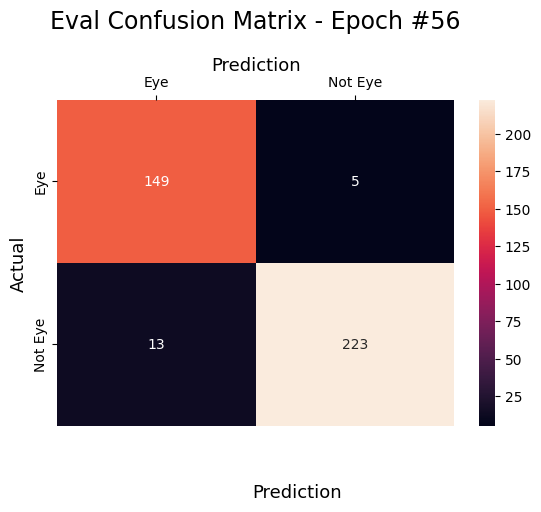

Epoch #57
Training: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1393
           1       0.99      0.91      0.95      2108

    accuracy                           0.94      3501
   macro avg       0.93      0.95      0.94      3501
weighted avg       0.94      0.94      0.94      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       154
           1       0.98      0.87      0.92       236

    accuracy                           0.91       390
   macro avg       0.90      0.92      0.91       390
weighted avg       0.92      0.91      0.91       390



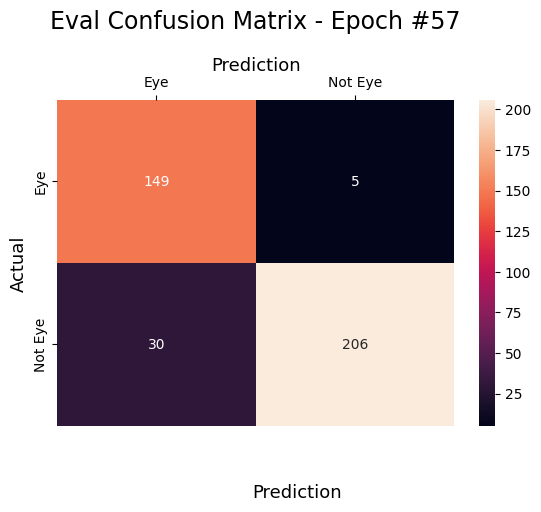

Epoch #58
Training: 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1393
           1       0.99      0.91      0.94      2108

    accuracy                           0.93      3501
   macro avg       0.93      0.94      0.93      3501
weighted avg       0.94      0.93      0.94      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       154
           1       0.97      0.96      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



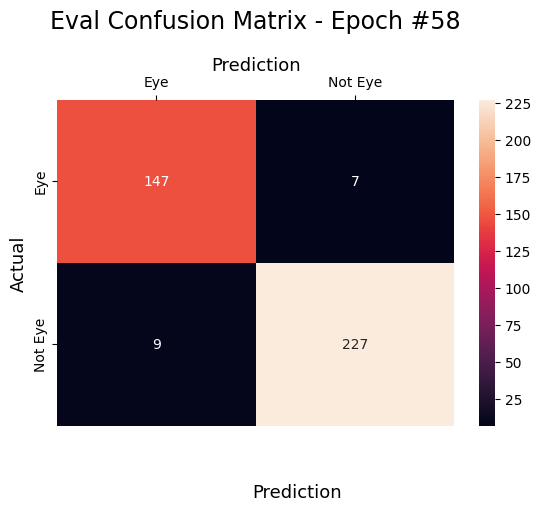

Epoch #59
Training: 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1393
           1       0.98      0.87      0.92      2108

    accuracy                           0.91      3501
   macro avg       0.91      0.92      0.91      3501
weighted avg       0.92      0.91      0.91      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       154
           1       0.95      0.96      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.95      0.95      0.95       390



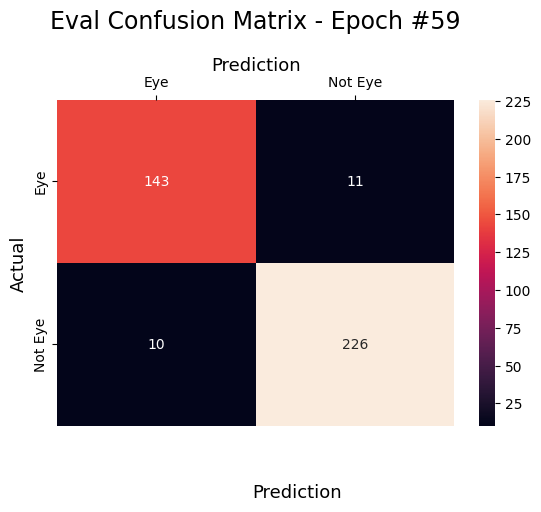

Epoch #60
Training: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1393
           1       0.97      0.95      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.94      0.95      0.94      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       154
           1       0.95      0.96      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.95      0.95      0.95       390



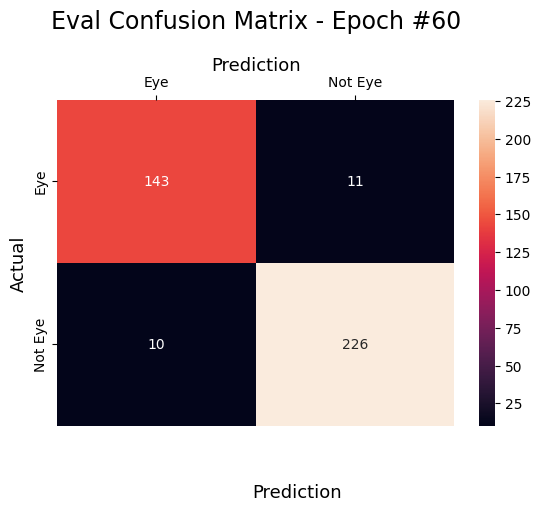

Epoch #61
Training: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1393
           1       0.98      0.96      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       154
           1       0.96      0.94      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



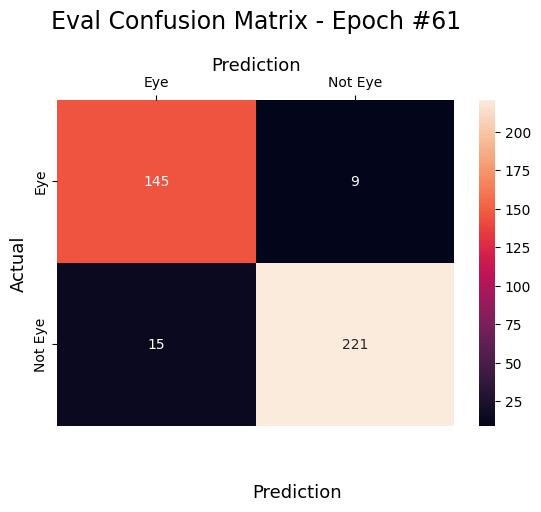

Epoch #62
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1393
           1       0.99      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



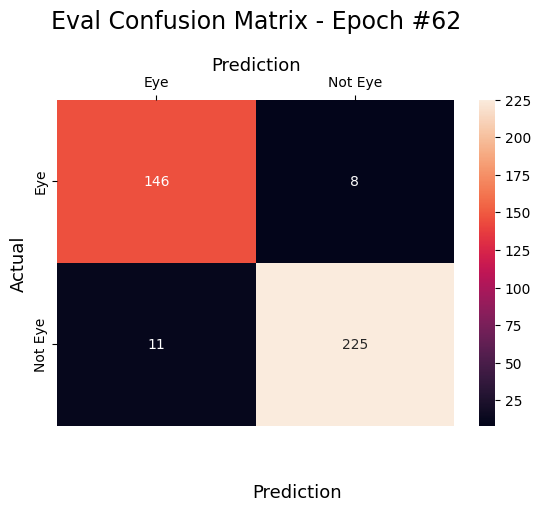

Epoch #63
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.98      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       154
           1       0.96      0.92      0.94       236

    accuracy                           0.93       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.93      0.93       390



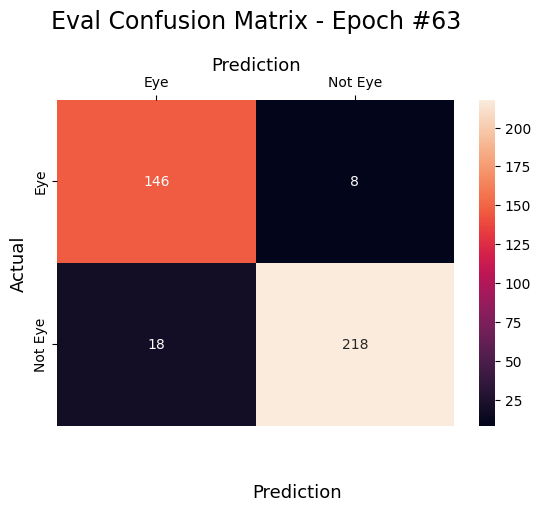

Epoch #64
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.95      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       154
           1       0.97      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.94      0.94       390



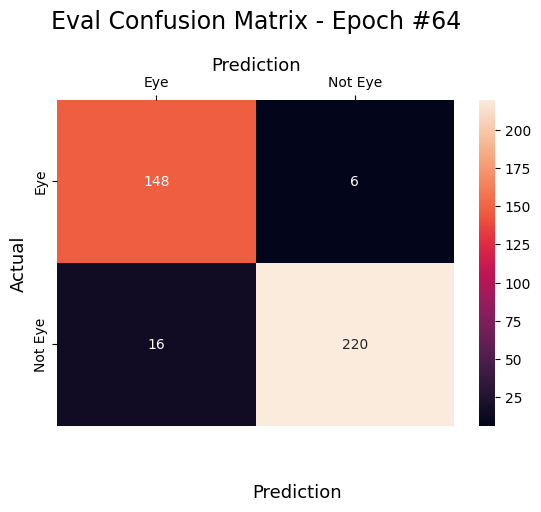

Epoch #65
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       154
           1       0.97      0.94      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



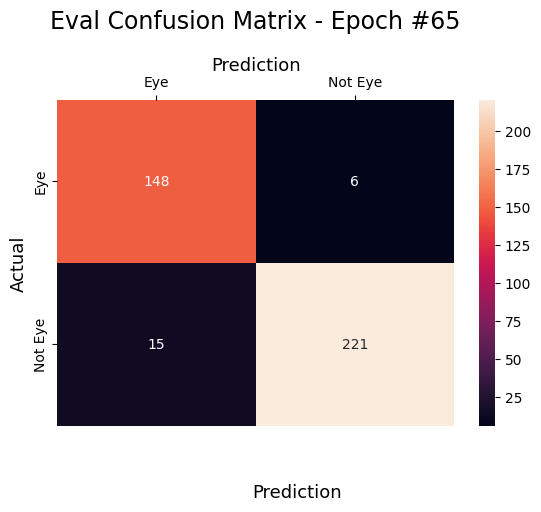

Epoch #66
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1393
           1       0.99      0.96      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       154
           1       0.97      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



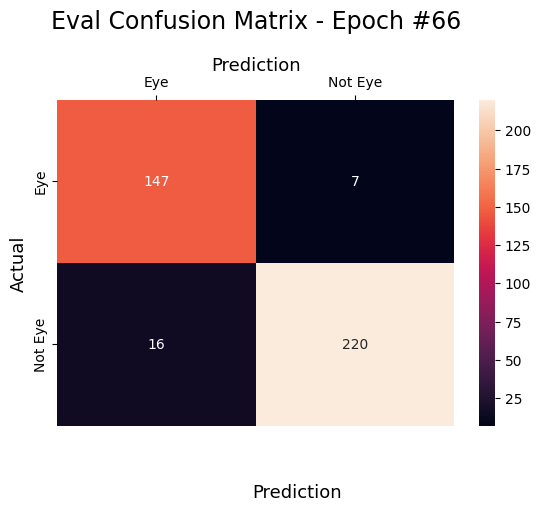

Epoch #67
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       154
           1       0.97      0.94      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



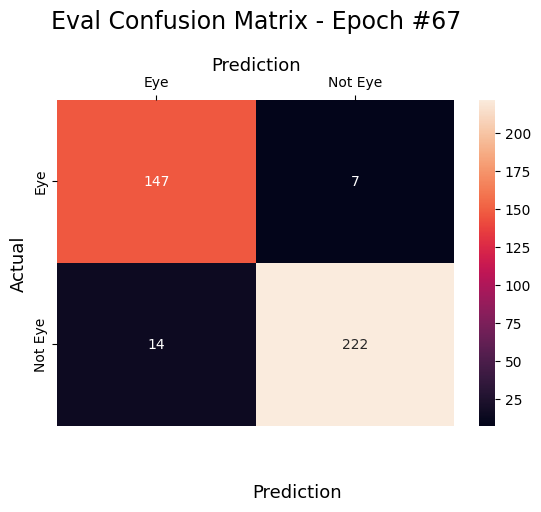

Epoch #68
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1393
           1       0.99      0.94      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.96      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       154
           1       0.98      0.96      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



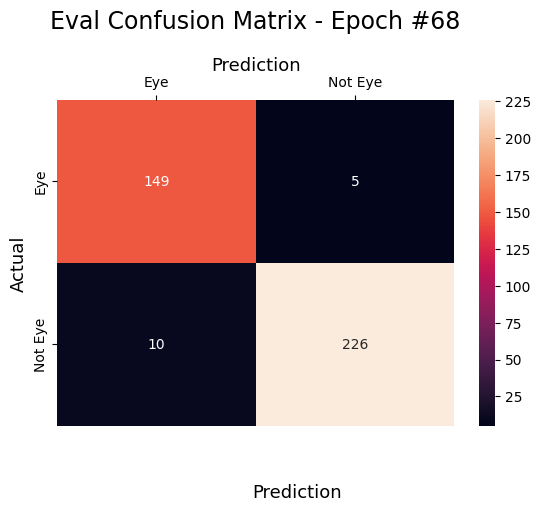

Epoch #69
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1393
           1       0.99      0.94      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.95      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



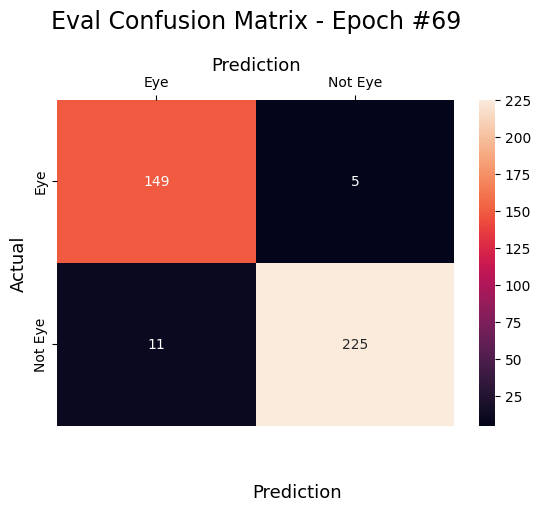

Epoch #70
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1393
           1       0.98      0.97      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       154
           1       0.98      0.96      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



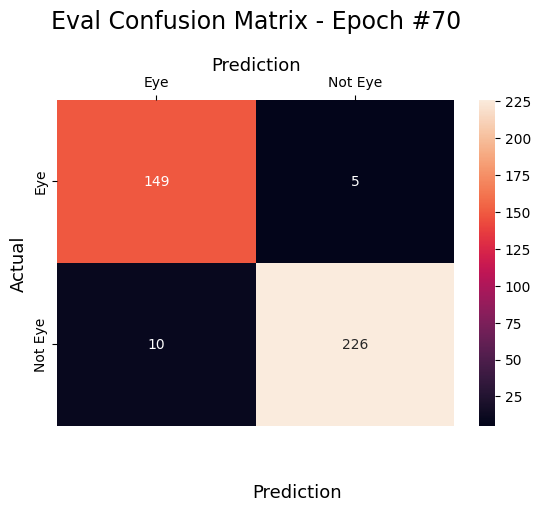

Epoch #71
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



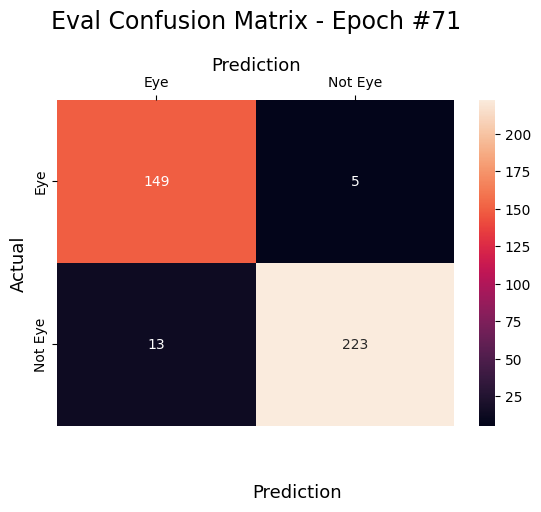

Epoch #72
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       154
           1       0.97      0.94      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



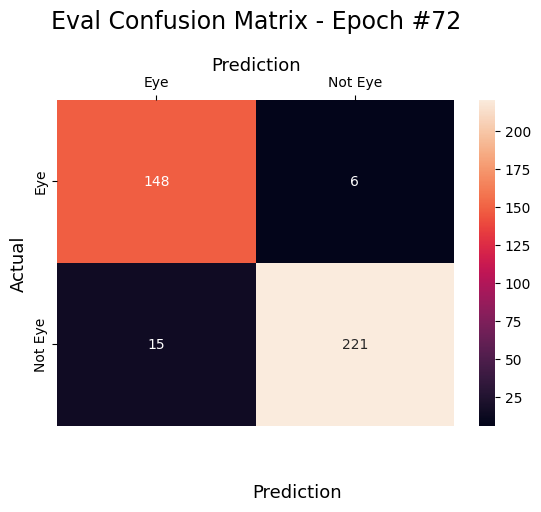

Epoch #73
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       154
           1       0.97      0.94      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



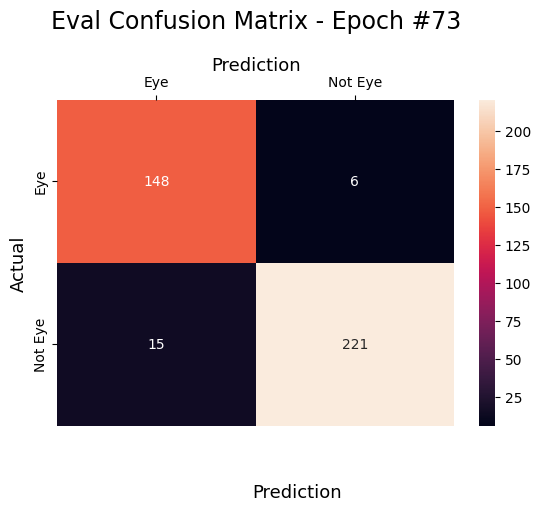

Epoch #74
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



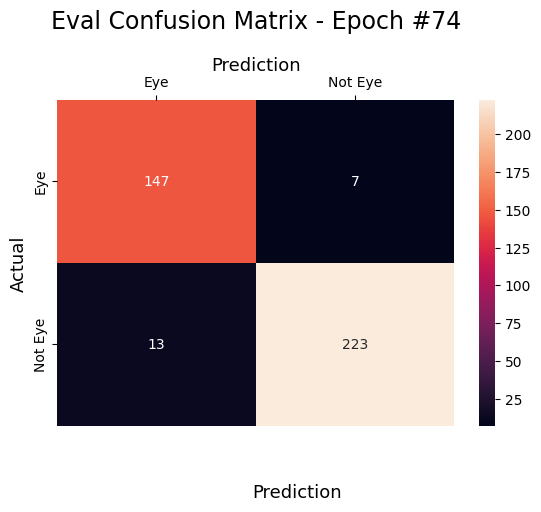

Epoch #75
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       154
           1       0.97      0.92      0.94       236

    accuracy                           0.93       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.93      0.93       390



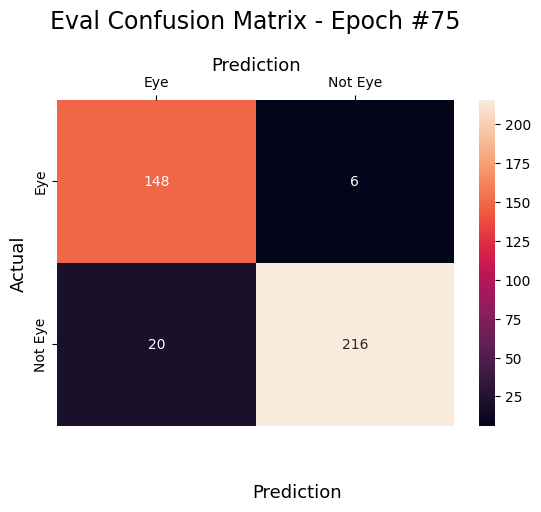

Epoch #76
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1393
           1       0.99      0.96      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



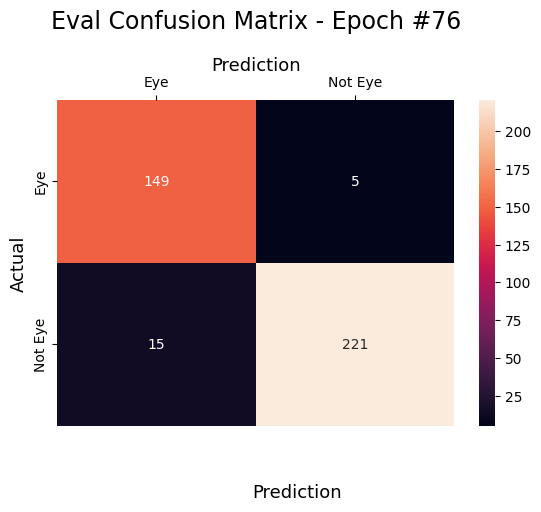

Epoch #77
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



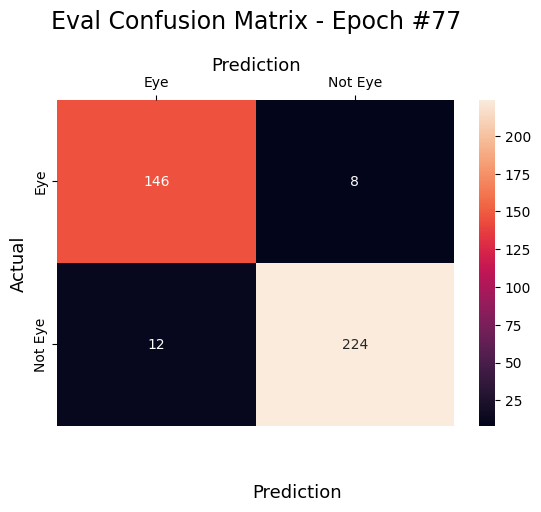

Epoch #78
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.95      0.95      0.95       390



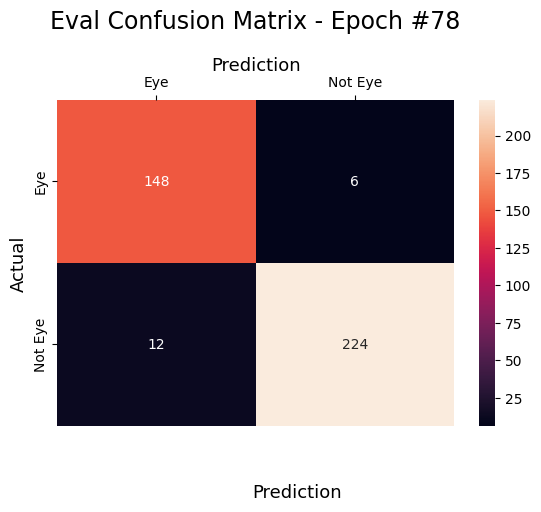

Epoch #79
Training: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1393
           1       0.99      0.92      0.95      2108

    accuracy                           0.95      3501
   macro avg       0.94      0.95      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



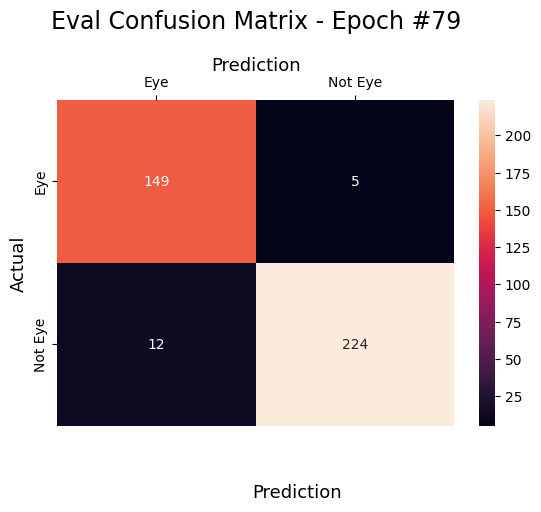

Epoch #80
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       154
           1       0.98      0.89      0.93       236

    accuracy                           0.92       390
   macro avg       0.91      0.93      0.92       390
weighted avg       0.93      0.92      0.92       390



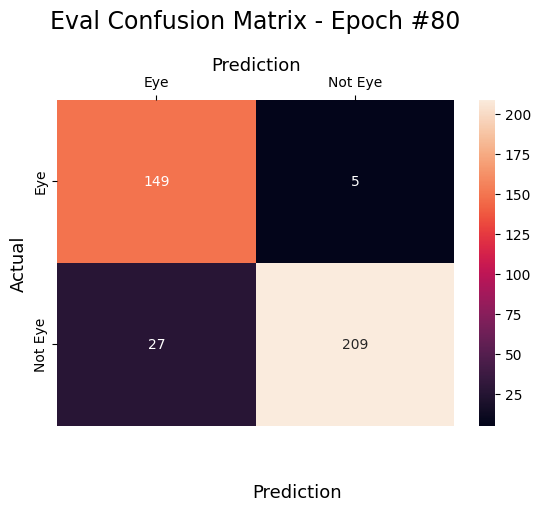

Epoch #81
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



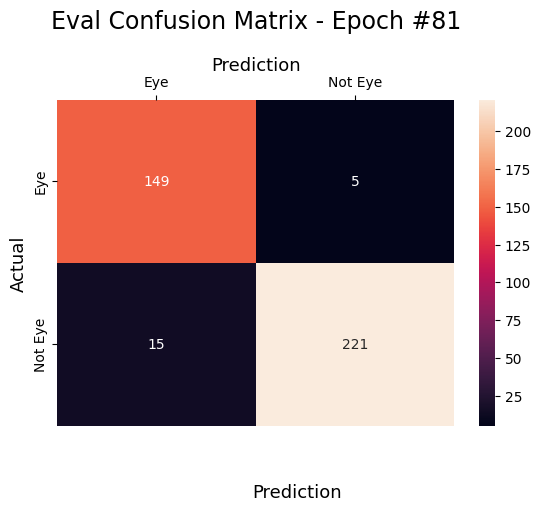

Epoch #82
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       154
           1       0.98      0.97      0.97       236

    accuracy                           0.97       390
   macro avg       0.96      0.97      0.97       390
weighted avg       0.97      0.97      0.97       390



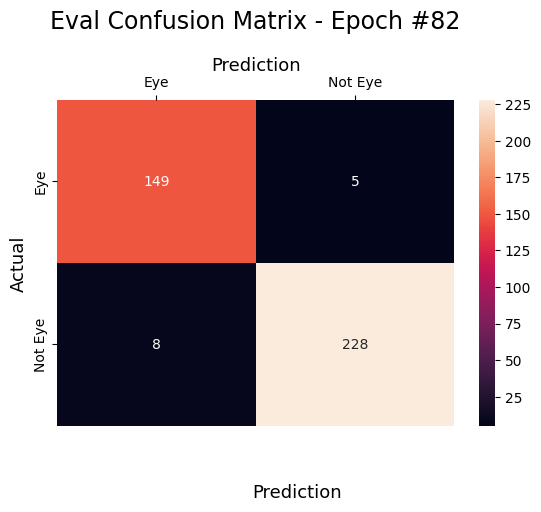

Epoch #83
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       154
           1       0.98      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.95      0.94       390
weighted avg       0.94      0.94      0.94       390



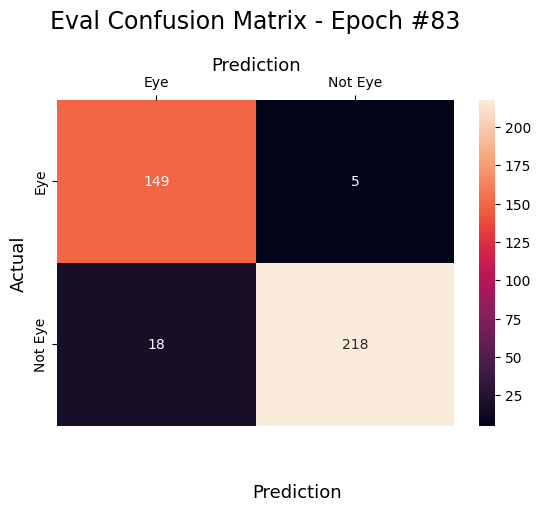

Epoch #84
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



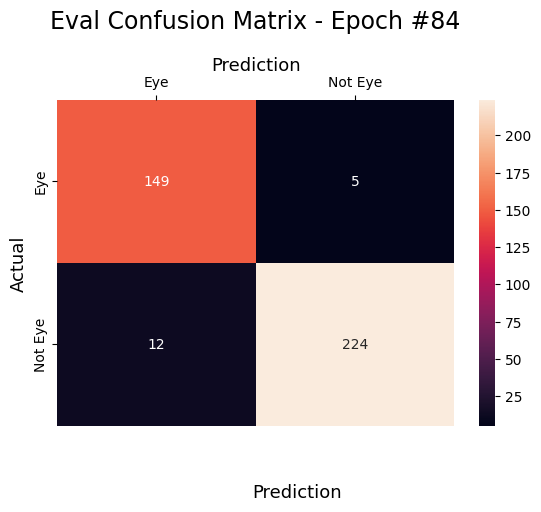

Epoch #85
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       154
           1       0.98      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.94      0.94       390



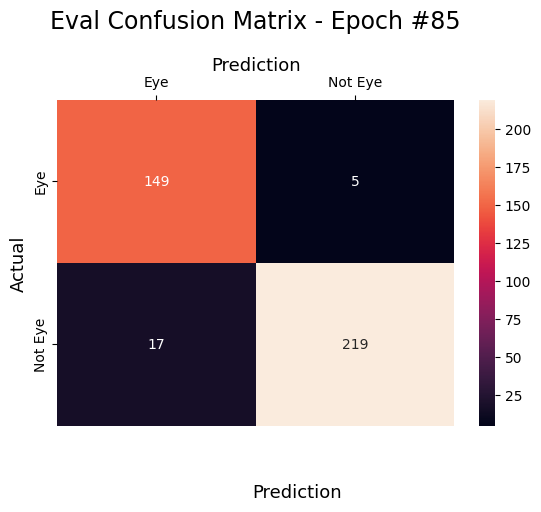

Epoch #86
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       154
           1       0.98      0.92      0.95       236

    accuracy                           0.94       390
   macro avg       0.93      0.95      0.94       390
weighted avg       0.94      0.94      0.94       390



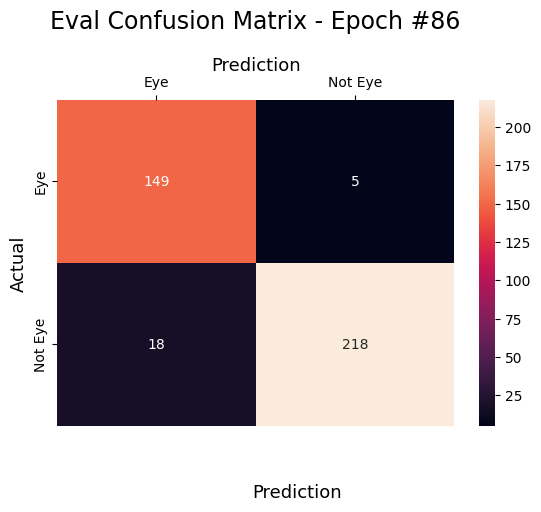

Epoch #87
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



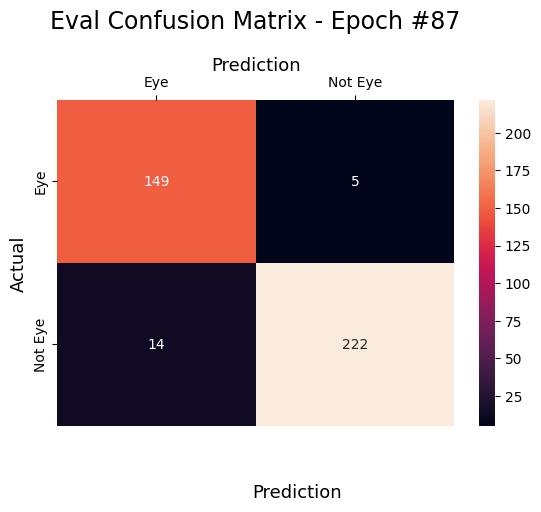

Epoch #88
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.98      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



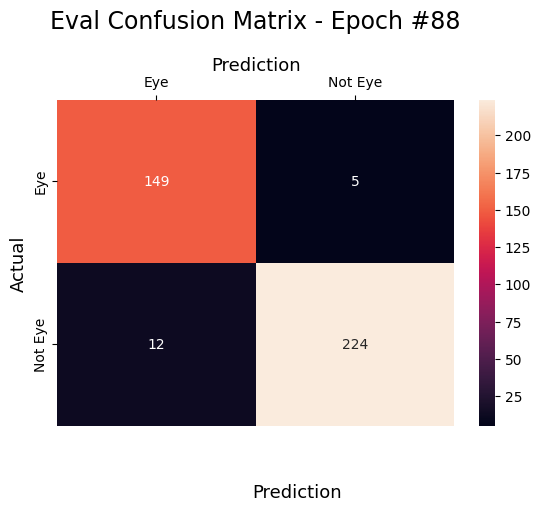

Epoch #89
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



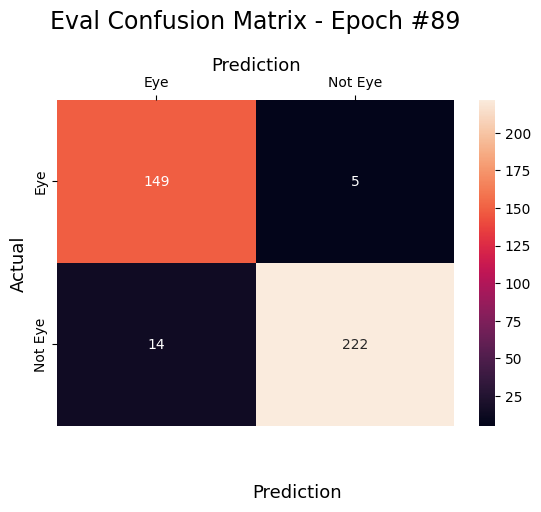

Epoch #90
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



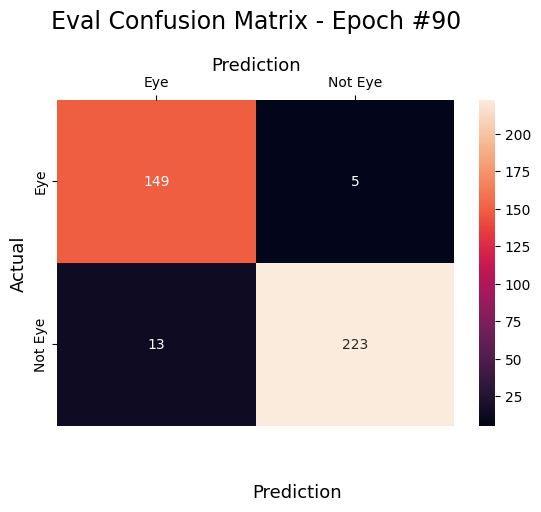

Epoch #91
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.98      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.98      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



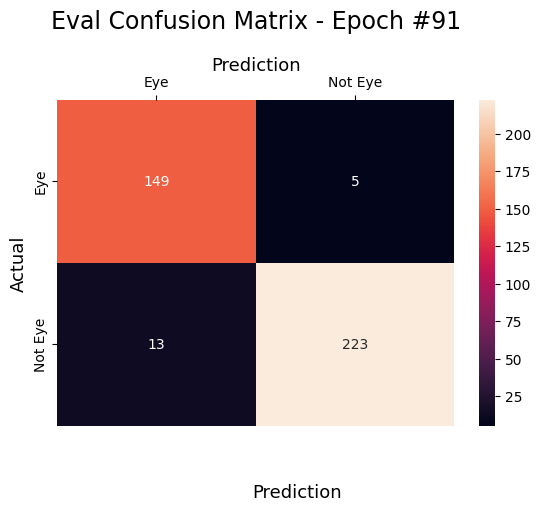

Epoch #92
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



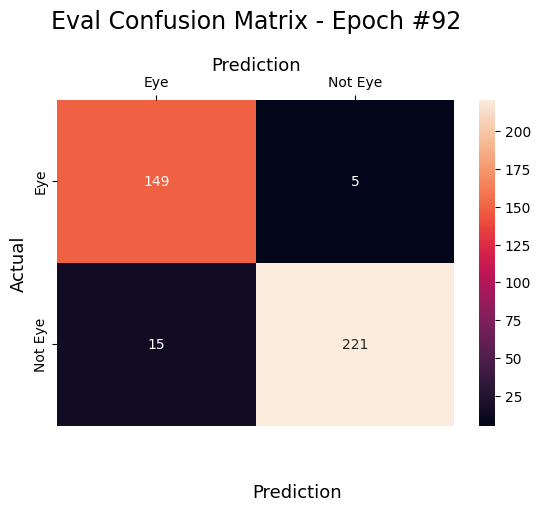

Epoch #93
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



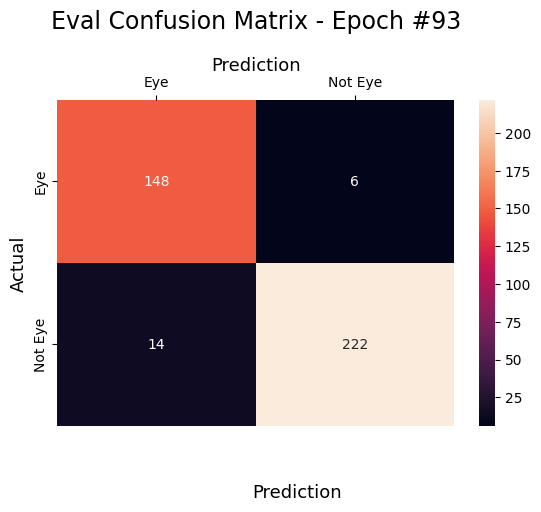

Epoch #94
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



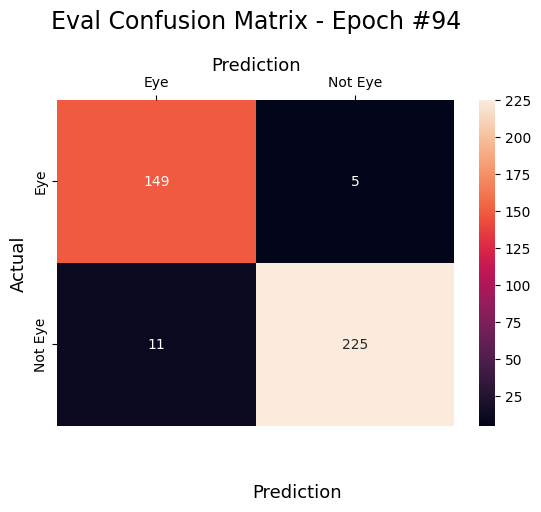

Epoch #95
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       154
           1       0.98      0.93      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.94      0.94       390



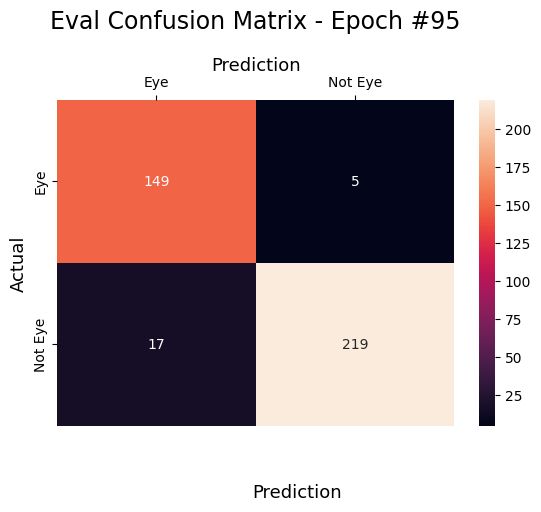

Epoch #96
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       154
           1       0.98      0.91      0.94       236

    accuracy                           0.93       390
   macro avg       0.93      0.94      0.93       390
weighted avg       0.94      0.93      0.93       390



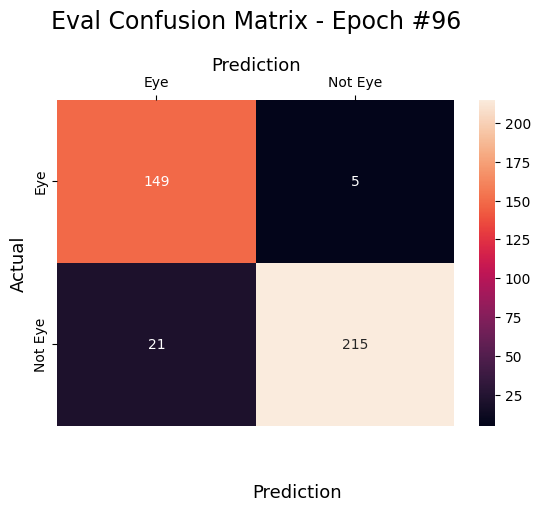

Epoch #97
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



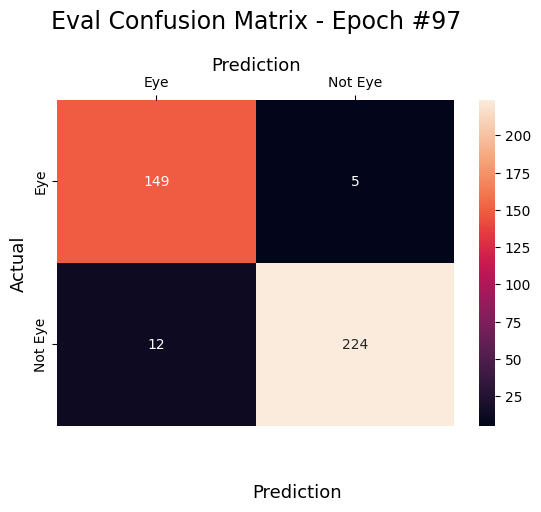

Epoch #98
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



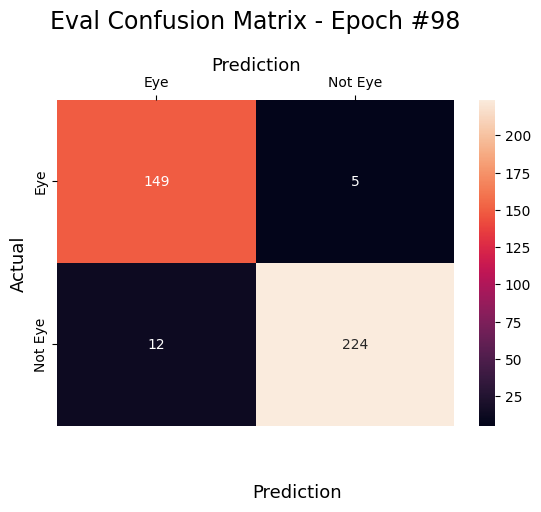

Epoch #99
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



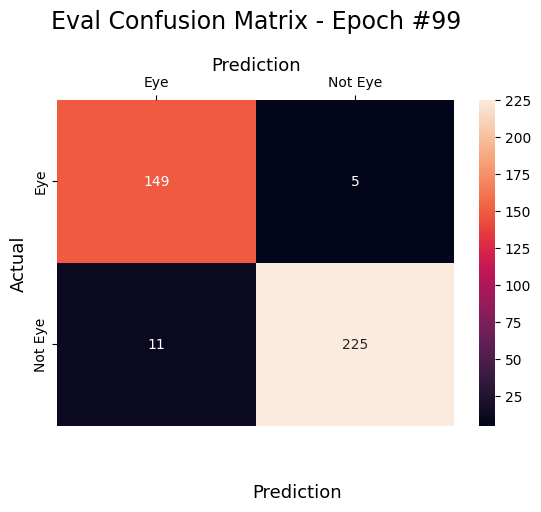

Epoch #100
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



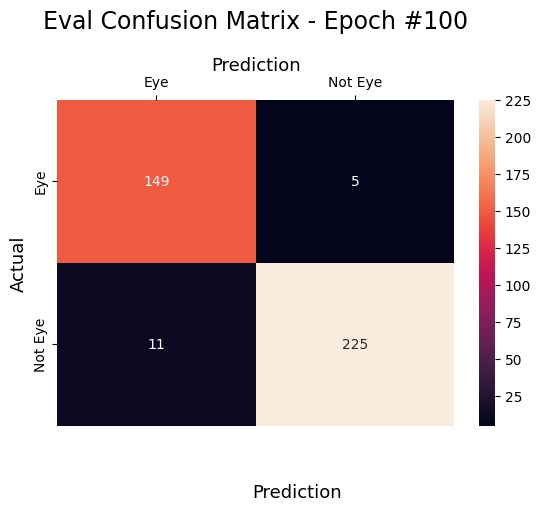

Epoch #101
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.98      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.98      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



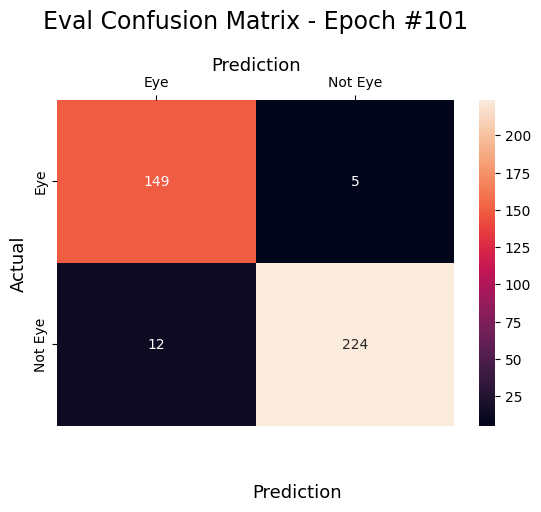

Epoch #102
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



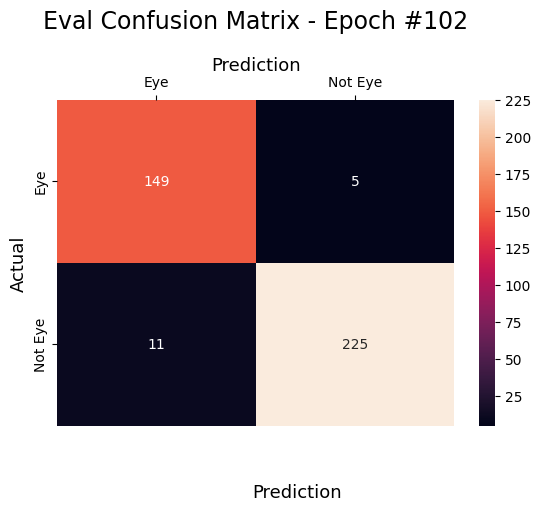

Epoch #103
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       154
           1       0.98      0.96      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



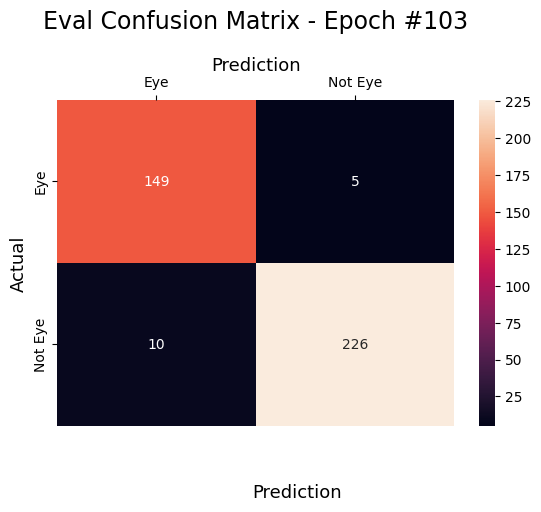

Epoch #104
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       154
           1       0.98      0.96      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



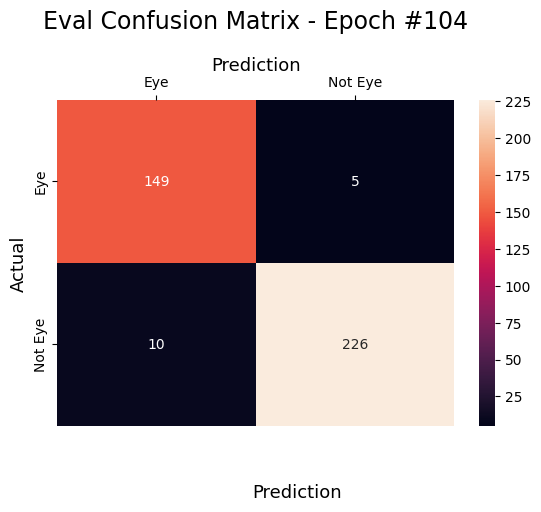

Epoch #105
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.95      0.95      0.95       390



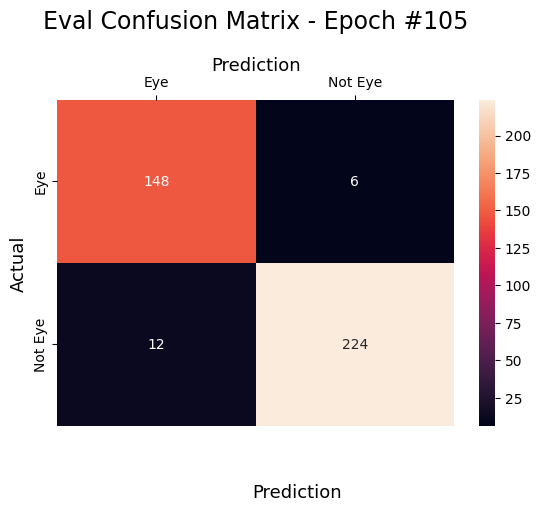

Epoch #106
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1393
           1       0.99      0.96      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       154
           1       0.98      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.95      0.95       390



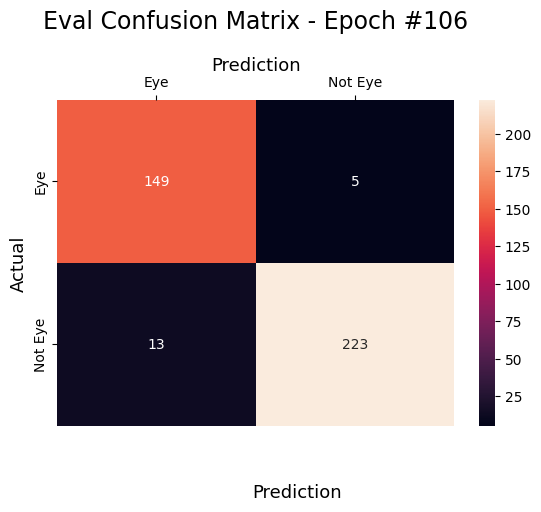

Epoch #107
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       154
           1       0.98      0.93      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



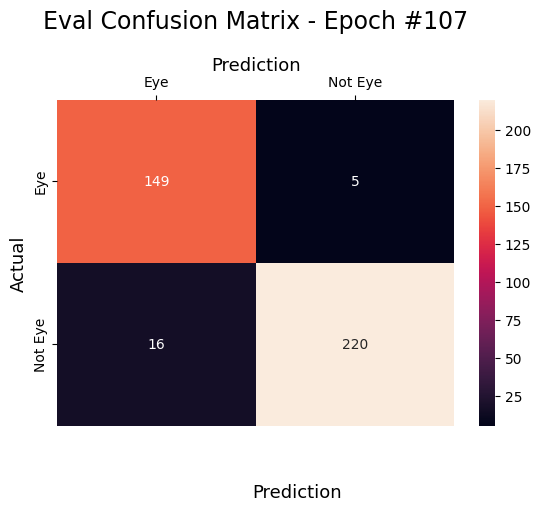

Epoch #108
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



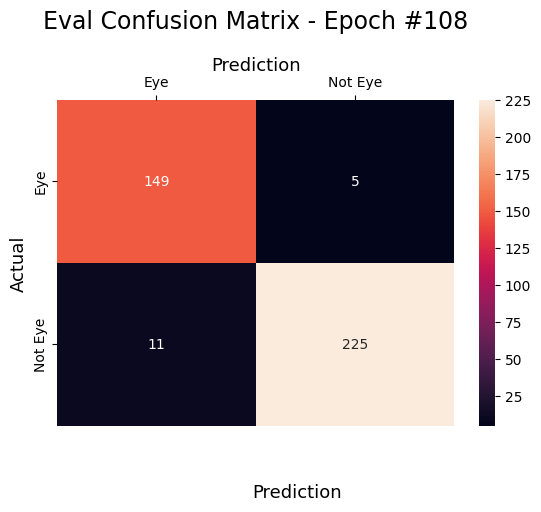

Epoch #109
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       154
           1       0.97      0.94      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.94      0.94      0.94       390



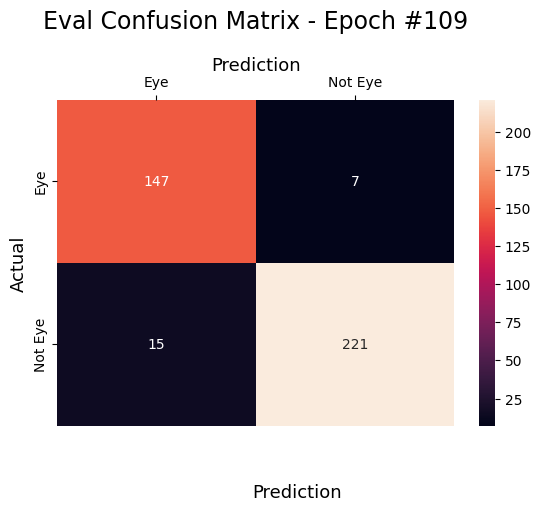

Epoch #110
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.97      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       154
           1       0.96      0.97      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



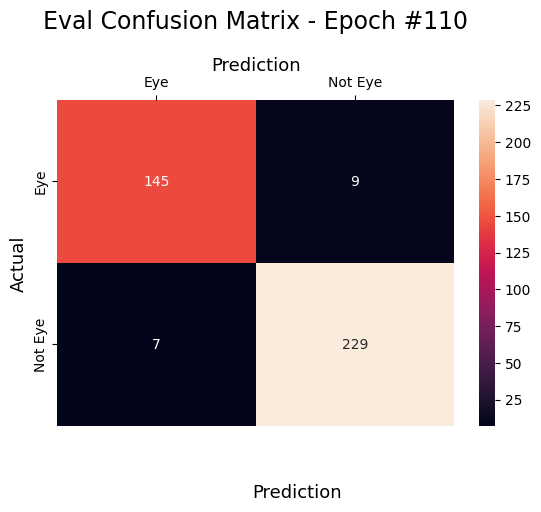

Epoch #111
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1393
           1       0.99      0.96      0.97      2108

    accuracy                           0.97      3501
   macro avg       0.96      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



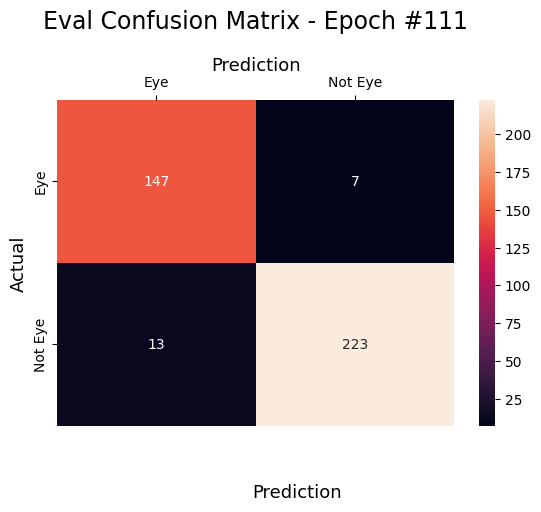

Epoch #112
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



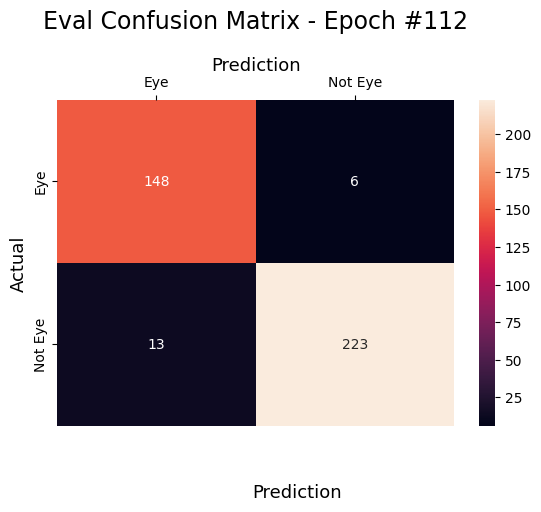

Epoch #113
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1393
           1       0.99      0.93      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.96      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       154
           1       0.97      0.94      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



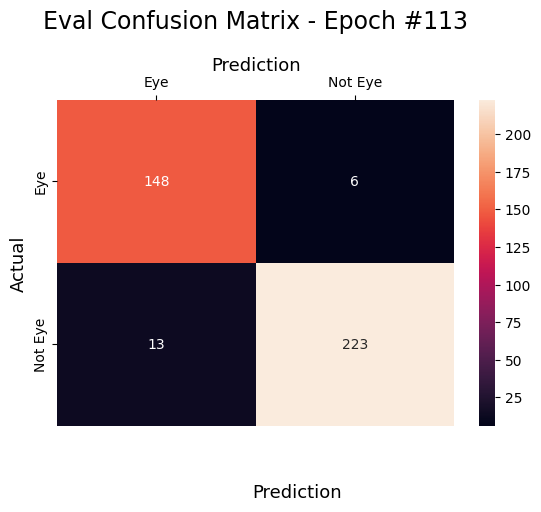

Epoch #114
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1393
           1       0.99      0.95      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.97      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       154
           1       0.94      0.98      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.94      0.95       390
weighted avg       0.95      0.95      0.95       390



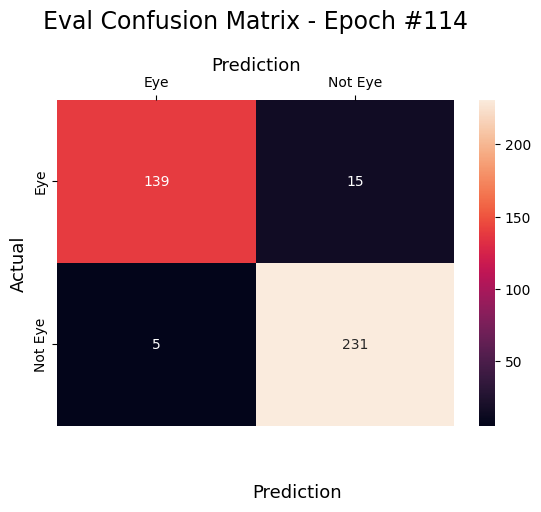

Epoch #115
Training: 
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1393
           1       0.95      0.97      0.96      2108

    accuracy                           0.95      3501
   macro avg       0.95      0.95      0.95      3501
weighted avg       0.95      0.95      0.95      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       154
           1       0.95      0.96      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.94      0.94       390
weighted avg       0.95      0.95      0.95       390



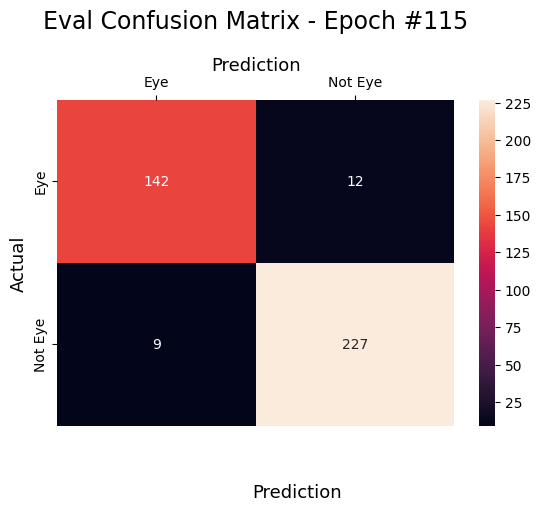

Epoch #116
Training: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1393
           1       0.96      0.97      0.97      2108

    accuracy                           0.96      3501
   macro avg       0.96      0.96      0.96      3501
weighted avg       0.96      0.96      0.96      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       154
           1       0.95      0.96      0.95       236

    accuracy                           0.94       390
   macro avg       0.94      0.94      0.94       390
weighted avg       0.94      0.94      0.94       390



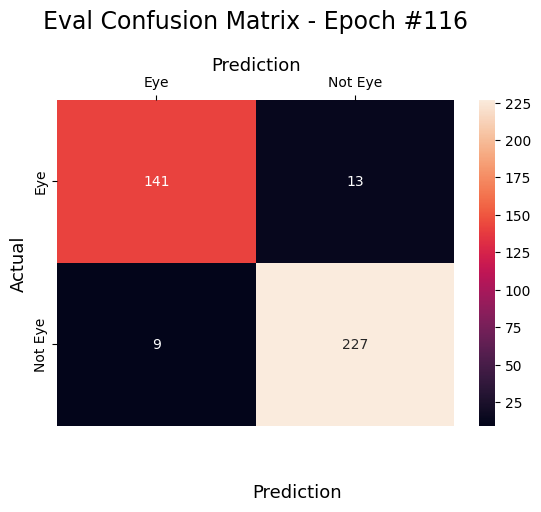

Epoch #117
Training: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1393
           1       0.98      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.95      0.95      0.95       390



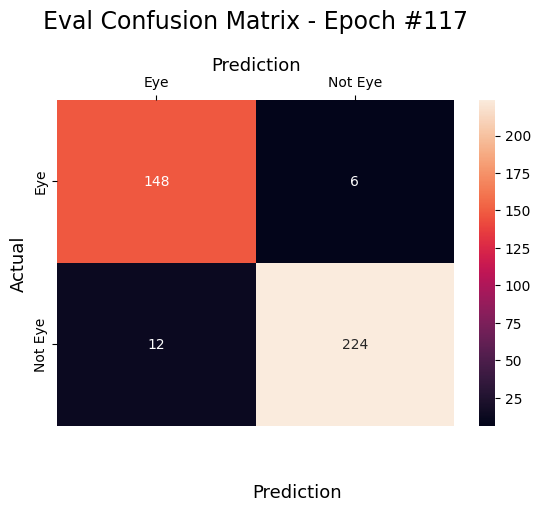

Epoch #118
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



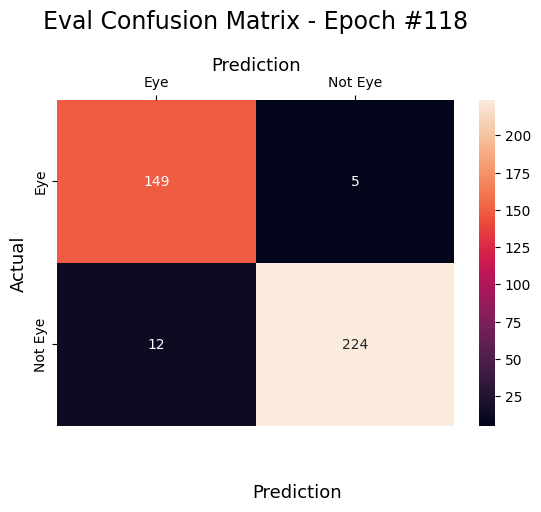

Epoch #119
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       154
           1       0.97      0.97      0.97       236

    accuracy                           0.96       390
   macro avg       0.96      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



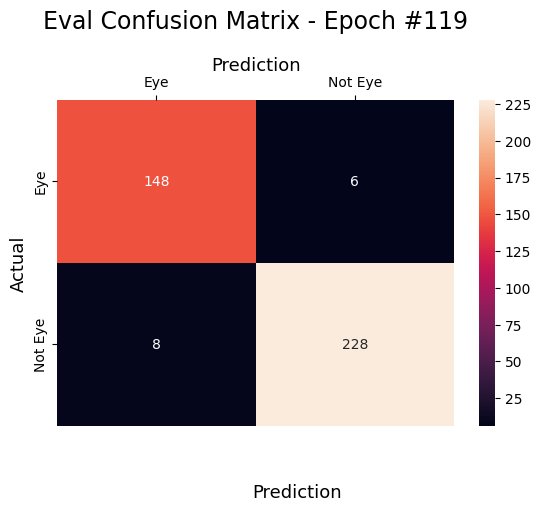

Epoch #120
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.98      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.98      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.98      0.95      0.97       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.96       390
weighted avg       0.96      0.96      0.96       390



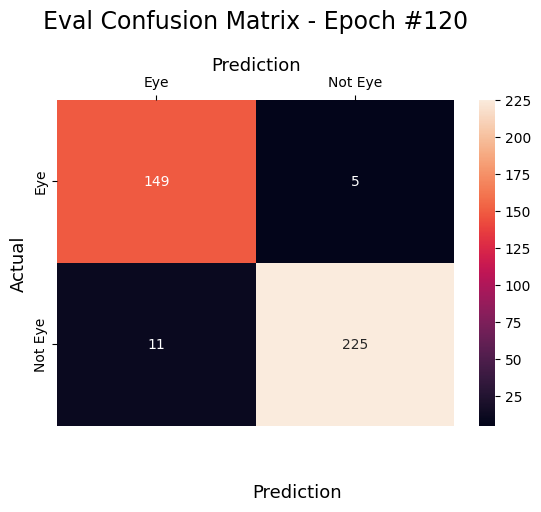

Epoch #121
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       154
           1       0.97      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



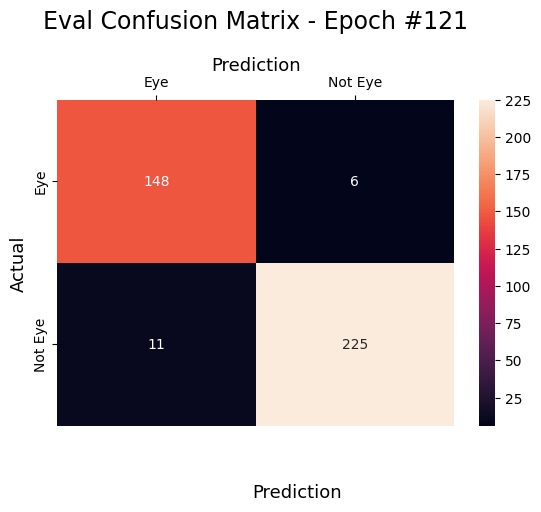

Epoch #122
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.98      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.98      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       154
           1       0.97      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



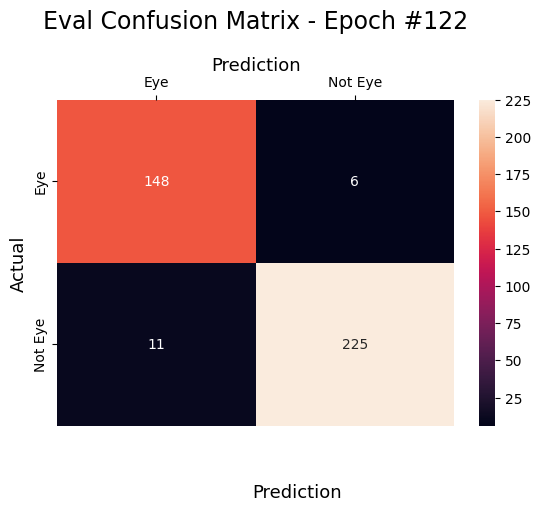

Epoch #123
Training: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1393
           1       0.99      0.98      0.98      2108

    accuracy                           0.98      3501
   macro avg       0.98      0.98      0.98      3501
weighted avg       0.98      0.98      0.98      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       154
           1       0.97      0.95      0.96       236

    accuracy                           0.95       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.95      0.95      0.95       390



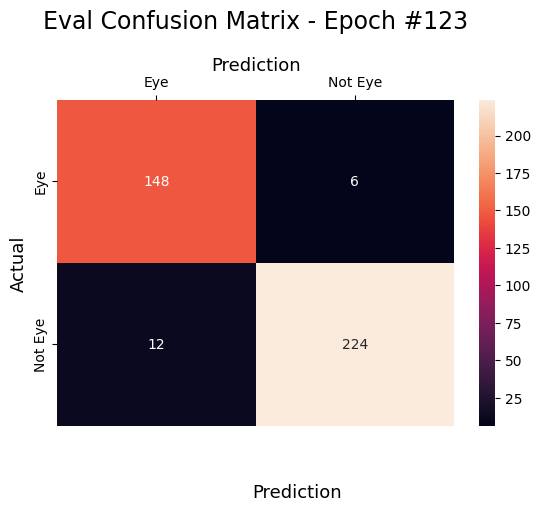

Epoch #124
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.97      0.97      3501
weighted avg       0.97      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       154
           1       0.97      0.95      0.96       236

    accuracy                           0.96       390
   macro avg       0.95      0.96      0.95       390
weighted avg       0.96      0.96      0.96       390



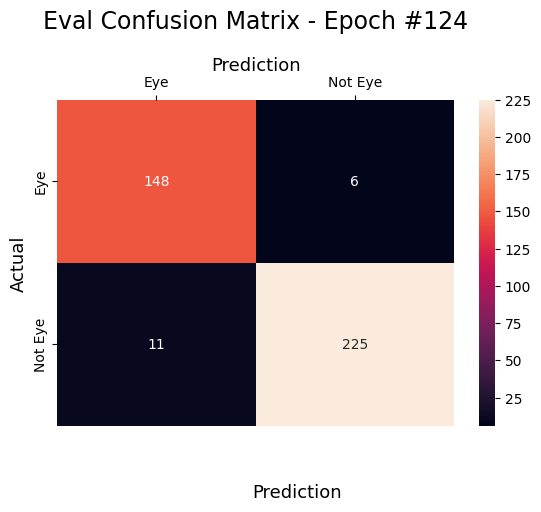

Epoch #125
Training: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1393
           1       0.99      0.97      0.98      2108

    accuracy                           0.97      3501
   macro avg       0.97      0.98      0.97      3501
weighted avg       0.98      0.97      0.97      3501

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       154
           1       0.98      0.93      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



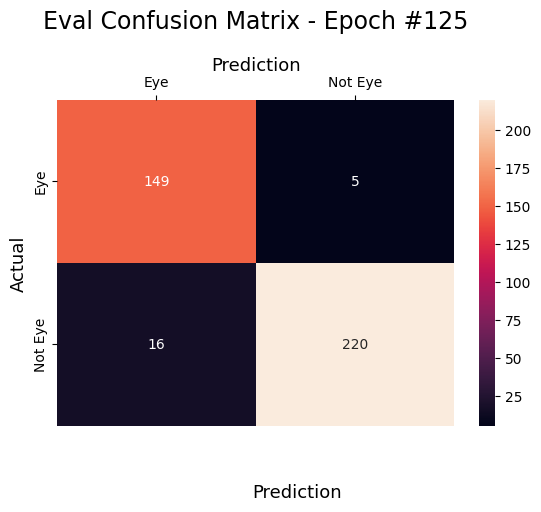

Eval/Accuracy,▄▃▁▆▅▇▇▇█▄█▇▇███▇▇██▇██████▇██▇█████████
Eval/F1-Score,▁▂▆▂▃▅▅▃▄▂▅▇▇▇█▇██▇█▇▇█▇▇▇▇█▇▇█████▇▇██▇
Eval/Precision,▅▁▂▇▃▆▄▄▅▇▇▂▆▇▇▃▅▇▇▇▇▇██▇█▆▇▅█▇▇▇██▇█▇▇▇
Eval/Recall,▃▇▄▁▆▆▅▄▆▇▄█▇▅██▇█▇▇▇▇████▇█▇███████▇███
Train/Accuracy,▁▂▃▄▃▁▇▇▇▇▆▆▇▇▇▇▇▇▇▆▅▇▇▇▇▇▇█▇█▇▇████▇▇██
Train/F1-Score,▁▃▃▄▆▂▅▅▄▃▂▇▇█▇▆▇▇▇██▇▆▇▇█▇█▇██▇███▇████
Train/Precision,▁▃▃▄▄▄▃▅▅▄▅▇▇▇▇▇▆▆▇▇▇▇▅▇▇▇▇█▆▇█▇▇███▇███
Train/Recall,▂▅▁▃▆▄▅▄▆▇▇▅▆▇▇▇█▇▇▆▆▇██▇▇▇████████▇▇▇██
Eval/Accuracy,0.94615
Eval/F1-Score,0.94431
Eval/Precision,0.9404


In [ ]:
for i in range(num_epochs):
    
    epoch_message = f"Epoch #{i+1}"
    print(epoch_message)
    f.write(epoch_message + "\n")
    
    train_actual, train_predicted = model_train(model, optimizer, criterion, train_loader)
    eval_actual, eval_predicted = model_eval(model, test_loader)
    
    train_report = classification_report(train_actual, train_predicted, output_dict=True)
    train_report_message = "Training: \n" + str(classification_report(train_actual, train_predicted, zero_division=0))
    print(train_report_message)
    f.write(train_report_message + "\n")
    
    eval_report = classification_report(eval_actual, eval_predicted, output_dict=True)
    eval_report_message = "Evaluation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
    print(eval_report_message)
    f.write(eval_report_message + "\n")
    
    wandb.log({
        "Train/Precision": train_report["macro avg"]['precision'], 
        "Train/Recall": train_report["macro avg"]['recall'],
        "Train/F1-Score": train_report["macro avg"]['f1-score'],
        "Train/Accuracy": train_report["accuracy"],
        
        "Eval/Precision": eval_report["macro avg"]['precision'], 
        "Eval/Recall": eval_report["macro avg"]['recall'],
        "Eval/F1-Score": eval_report["macro avg"]['f1-score'],
        "Eval/Accuracy": eval_report["accuracy"]
    })
    
    create_confusion_matrix(eval_actual, eval_predicted, i)
    
    

wandb.finish()   


Validation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       154
           1       0.98      0.93      0.95       236

    accuracy                           0.95       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.95      0.95      0.95       390



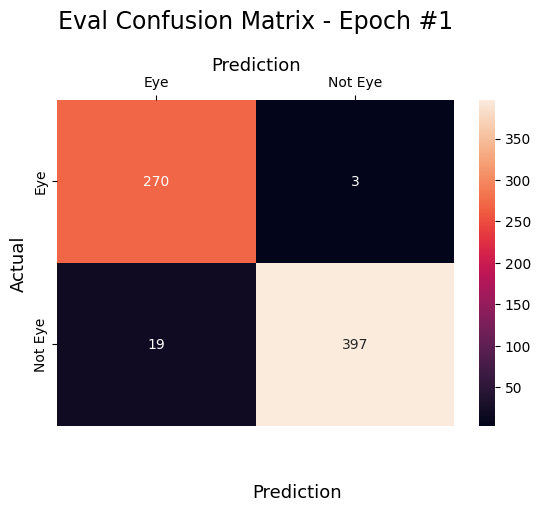

In [18]:
validation_actual, validation_predicted = model_eval(model, val_loader)

validation_report = classification_report(validation_actual, validation_predicted, output_dict=True)
validation_report_message = "Validation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
f.write(validation_report_message + "\n")
print(validation_report_message)
    
create_confusion_matrix(validation_actual, validation_predicted, 0)
f.close() 

In [19]:
torch.save(model.state_dict(), "../info/models/validation/" + model_name + ".pth")